In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input, Layer, Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from pandas_datareader import data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC#Download data from the web via this package


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [465]:
GSPC = pd.read_csv('GSPC_index_close_test123.csv')
GSPC['Date']=pd.to_datetime(GSPC['Date'])
GSPC.set_index('Date', inplace=True)
GSPC=GSPC.T
GSPC_noisy = pd.DataFrame(np.repeat(GSPC.values,100,axis=0), columns=GSPC.columns)
GSPC_noisy

Date   2017-01-03  2017-01-04  2017-01-05  2017-01-06   2017-01-09  \
0     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
1     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
2     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
3     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
4     2257.830078     2270.75      2269.0  2276.97998  2268.899902   
..            ...         ...         ...         ...          ...   
95    2257.830078     2270.75      2269.0  2276.97998  2268.899902   
96    2257.830078     2270.75      2269.0  2276.97998  2268.899902   
97    2257.830078     2270.75      2269.0  2276.97998  2268.899902   
98    2257.830078     2270.75      2269.0  2276.97998  2268.899902   
99    2257.830078     2270.75      2269.0  2276.97998  2268.899902   

Date   2017-01-10   2017-01-11   2017-01-12   2017-01-13   2017-01-17  ...  \
0     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
1     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
2     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
3     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
4     2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
..            ...          ...          ...          ...          ...  ...   
95    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
96    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
97    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
98    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   
99    2268.899902  2275.320068  2270.439941  2274.639893  2267.889893  ...   

Date   2018-12-17   2018-12-18   2018-12-19   2018-12-20   2018-12-21  \
0     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
1     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
2     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
3     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
4     2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
..            ...          ...          ...          ...          ...   
95    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
96    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
97    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
98    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   
99    2545.939941  2546.159912  2506.959961  2467.419922  2416.620117   

Date   2018-12-24   2018-12-26   2018-12-27  2018-12-28   2018-12-31  
0     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
1     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
2     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
3     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
4     2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
..            ...          ...          ...         ...          ...  
95    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
96    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
97    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
98    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  
99    2351.100098  2467.699951  2488.830078  2485.73999  2506.850098  

[100 rows x 502 columns]

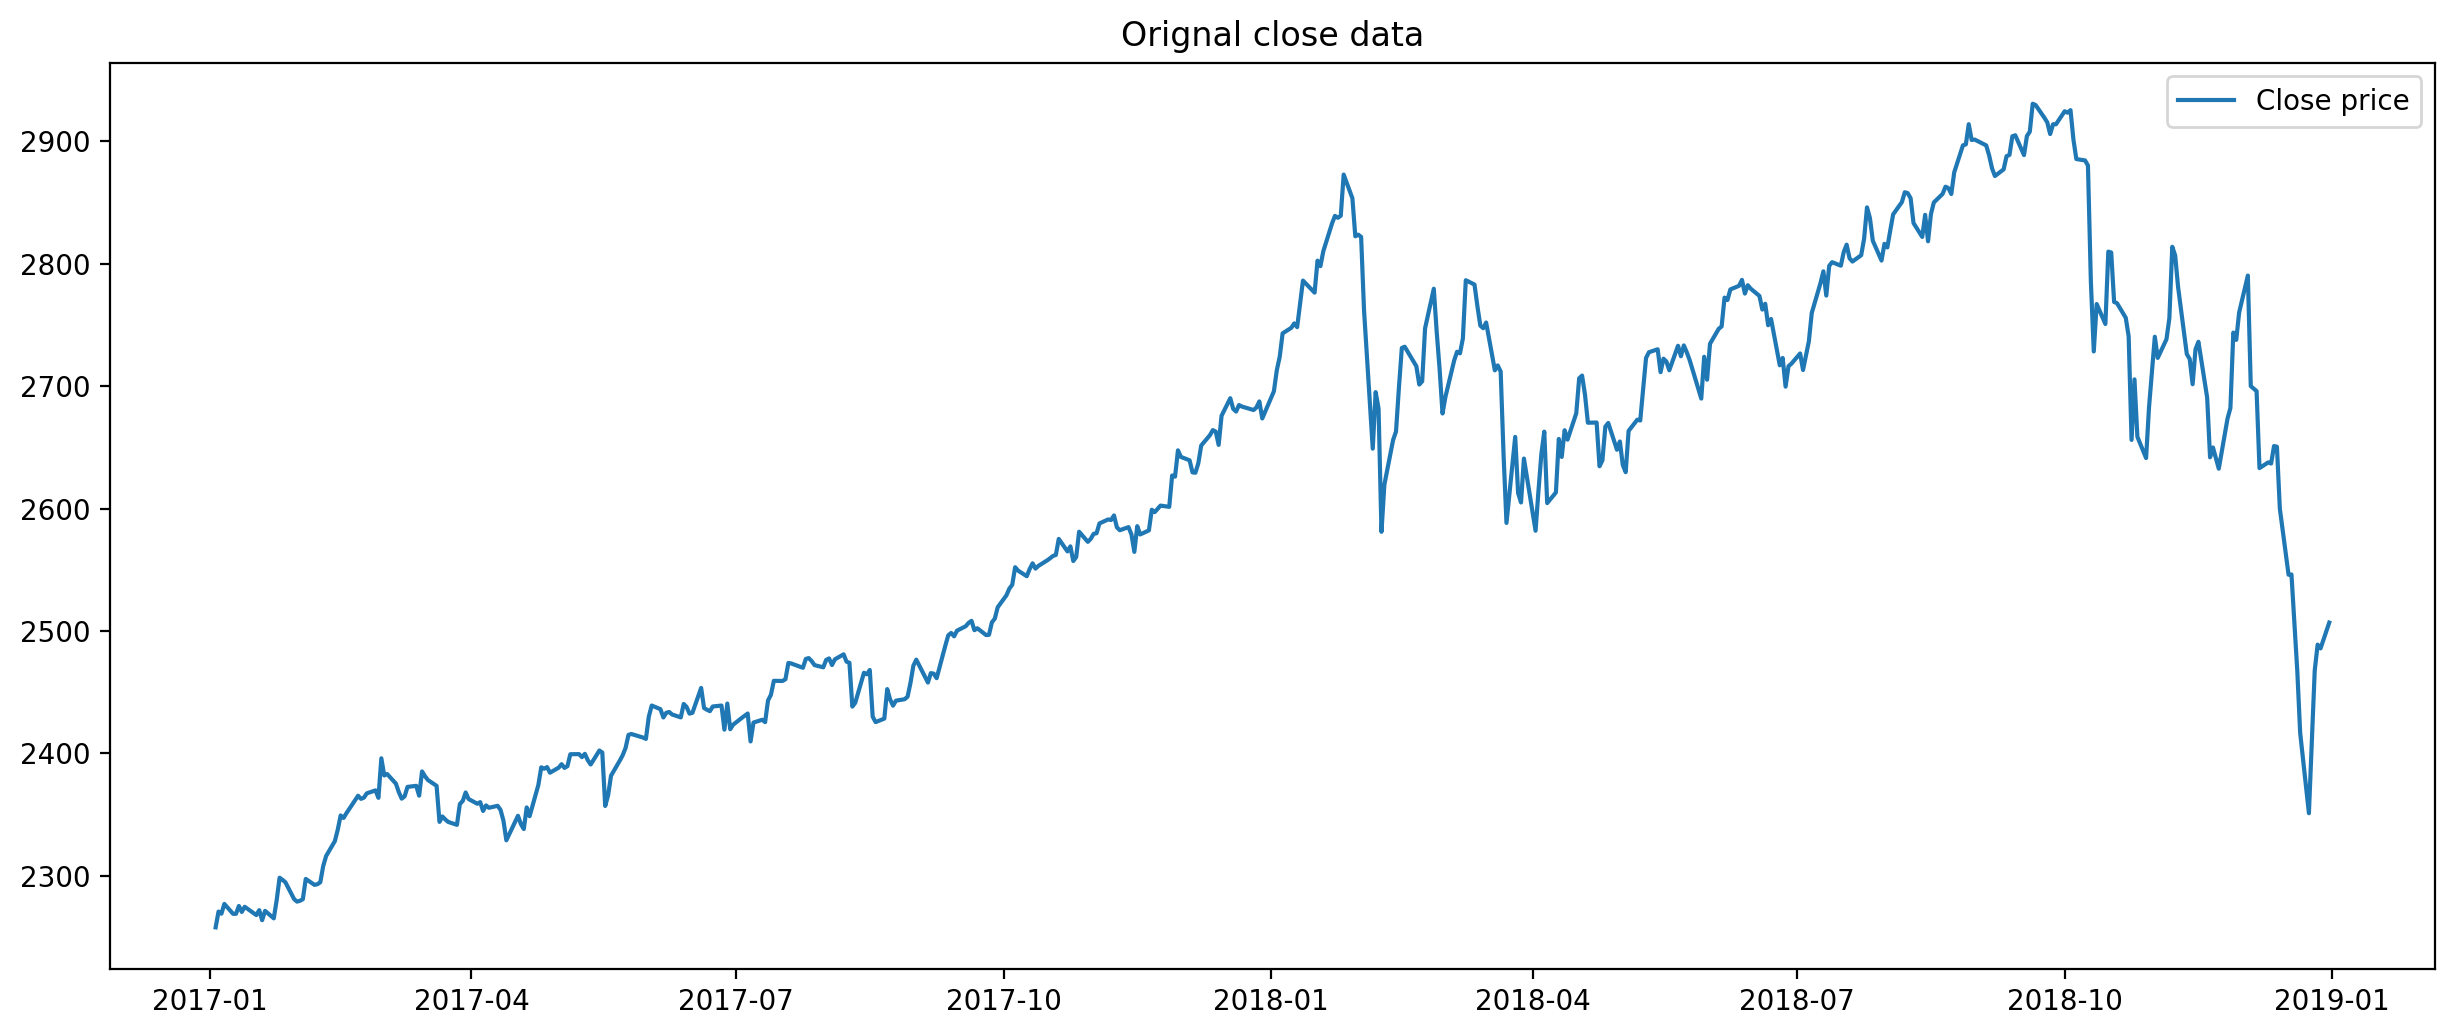

In [596]:
plt.figure(figsize=(15,6),dpi=200)
plt.plot(GSPC_noisy.iloc[0],label='Close price')
plt.title('Orignal close data')
plt.legend()

In [507]:
GSPC_T=GSPC.T
GSPC_pure=pd.DataFrame(columns=GSPC.columns)
for window in range(2,52):#SMA and EMA of the day, which using today's price and is the next day's SMA and EMA
    rolling_mean = GSPC_T['Close'].rolling(window,min_periods=1).mean()
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  GSPC_T['Close'].ewm(span=window,min_periods=1).mean()
    GSPC_pure=pd.concat([GSPC_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
GSPC_pure#


Date   2017-01-03   2017-01-04   2017-01-05   2017-01-06   2017-01-09  \
0     2257.830078  2264.290039     2269.875   2272.98999  2272.939941   
1     2257.830078  2264.290039  2265.860026  2272.243327  2271.626628   
2     2257.830078  2264.290039  2265.860026  2268.640015  2271.407471   
3     2257.830078  2264.290039  2265.860026  2268.640015  2268.691992   
4     2257.830078  2264.290039  2265.860026  2268.640015  2268.691992   
..            ...          ...          ...          ...          ...   
95    2257.830078  2264.427485  2266.016965  2268.935088   2268.92744   
96    2257.830078  2264.424622  2266.013727  2268.928967   2268.92266   
97    2257.830078  2264.421875  2266.010619  2268.923095   2268.91807   
98    2257.830078  2264.419238  2266.007635  2268.917456  2268.913659   
99    2257.830078  2264.416705  2266.004766  2268.912038  2268.909417   

Date   2017-01-10   2017-01-11   2017-01-12   2017-01-13   2017-01-17  ...  \
0     2268.899902  2272.109985  2272.880005  2272.539917  2271.264893  ...   
1     2271.593262  2271.039958  2271.553304  2273.466634  2270.989909  ...   
2     2270.944946  2272.524963  2270.889954  2272.324951  2272.072449  ...   
3     2270.905957  2271.819971  2272.107959  2271.639941  2271.437939  ...   
4     2268.726644  2271.641642  2271.589966  2272.529948  2271.014933  ...   
..            ...          ...          ...          ...          ...  ...   
95    2268.922348  2269.957027  2270.026755  2270.630799  2270.301319  ...   
96    2268.918461  2269.951171   2270.02154  2270.624275  2270.296787  ...   
97    2268.914725  2269.945548  2270.016528  2270.618008  2270.292425  ...   
98    2268.911131  2269.940144  2270.011708  2270.611983  2270.288223  ...   
99    2268.907671  2269.934947  2270.007068  2270.606186  2270.284172  ...   

Date   2018-12-17   2018-12-18   2018-12-19   2018-12-20   2018-12-21  \
0     2572.944946  2546.049927  2526.559937  2487.189941   2442.02002   
1     2598.809977  2564.016602  2533.019938  2506.846598  2463.666667   
2        2611.875  2585.647461  2549.752441  2516.619934  2484.289978   
3     2616.856006  2598.731982  2569.909961  2533.285937  2496.619971   
4     2620.333333  2605.073324  2583.436646  2552.828288  2513.841634   
..            ...          ...          ...          ...          ...   
95    2716.633637  2709.530565  2701.090123  2691.353864  2679.906625   
96    2717.947105  2710.935383  2702.609856  2693.010266  2681.729036   
97    2719.229206  2712.306434  2704.092575  2694.625669  2683.505447   
98    2720.480251  2713.644159  2705.538897  2696.200898  2685.236945   
99    2721.700579  2714.949014  2706.949435  2697.736762  2686.924583   

Date   2018-12-24   2018-12-26   2018-12-27   2018-12-28   2018-12-31  
0     2383.860107  2409.400024  2478.265015  2487.285034  2496.295044  
1     2411.713379  2411.806722  2435.876709  2480.756673  2493.806722  
2     2435.525024  2425.710022  2431.062561  2448.342529  2487.280029  
3     2457.652002   2441.96001  2438.334033  2441.998047  2460.044043  
4     2472.366659   2459.32666  2449.771688  2446.235026  2452.806722  
..            ...          ...          ...          ...          ...  
95    2666.206353  2657.935253  2650.889204  2644.007987  2638.293075  
96    2668.233977  2660.048915  2653.060391  2646.230987  2640.541971  
97    2670.209233  2662.108862   2655.17771  2648.400202  2642.738197  
98     2672.13354  2664.116536  2657.242557  2650.516966  2644.882972  
99    2674.008257  2666.073322  2659.256274  2652.582571  2646.977476  

[100 rows x 502 columns]

## MinMaxScaler

In [510]:
mm = MinMaxScaler()
noise_mm = mm.fit_transform(GSPC_noisy.T).T
prue_mm=mm.transform(GSPC_pure.T).T
prue_mm.shape

(100, 502)

In [511]:
train_cleaned_mm=np.reshape(prue_mm, (100, 502, 1))
train_mm=np.reshape(noise_mm, (100, 502, 1))

In [512]:
# convert list to numpy array
X_train_mm = np.asarray(train_mm)
Y_train_mm = np.asarray(train_cleaned_mm)
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0)

## LSTM

In [576]:
def set_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, input_shape=(None, 1),activation='tanh', return_sequences = True))
    model.add(LSTM(64, activation='tanh',return_sequences = True))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding='same'))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='tanh',return_sequences = True))
    model.add(LSTM(128, activation='tanh',return_sequences = True))
    model.add(BatchNormalization())
    model.add(UpSampling1D(2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])
    return model
modelen_LSTM = set_model_LSTM()
modelen_LSTM.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, None, 128)         66560     
                                                                 
 lstm_33 (LSTM)              (None, None, 64)          49408     
                                                                 
 batch_normalization_46 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_34 (LSTM)              (None, None, 64)        

In [577]:
callback = EarlyStopping(monitor='loss', patience=30)
history_LSTM = modelen_LSTM.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
3/3 [==============================] - 10s 2s/step - loss: 0.1367 - mse: 0.1367 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 2/400
3/3 [==============================] - 3s 1s/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0684 - val_mse: 0.0684
Epoch 3/400
3/3 [==============================] - 3s 1s/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0676 - val_mse: 0.0676
Epoch 4/400
3/3 [==============================] - 3s 1s/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0672 - val_mse: 0.0672
Epoch 5/400
3/3 [==============================] - 3s 1s/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 6/400
3/3 [==============================] - 3s 1s/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0662 - val_mse: 0.0662
Epoch 7/400
3/3 [==============================] - 3s 1s/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0653 - val_mse: 0.0653
Epoch 8/400
3/3 [==============================] - 3s 1s/step - loss: 0.0025 - mse: 0.0025 - val_loss: 

3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0390 - val_mse: 0.0390
Epoch 65/400
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 66/400
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 67/400
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 68/400
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 69/400
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 70/400
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 71/400
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0368

3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 128/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 129/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 130/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 131/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 132/400
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 133/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 134/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss:

3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 191/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 192/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 193/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 194/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 195/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 196/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 197/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss:

3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 254/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 255/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 256/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 257/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 258/400
3/3 [==============================] - 3s 1s/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 259/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 260/400
3/3 [==============================] - 3s 1s/step - loss: 0.0011 - mse: 0.0011 - val_loss:

In [579]:
modelen_LSTM.save_weights('model_weights_LSTM.h5', overwrite=True) 

In [519]:
modelen_LSTM.load_weights('model_weights_LSTM.h5') 

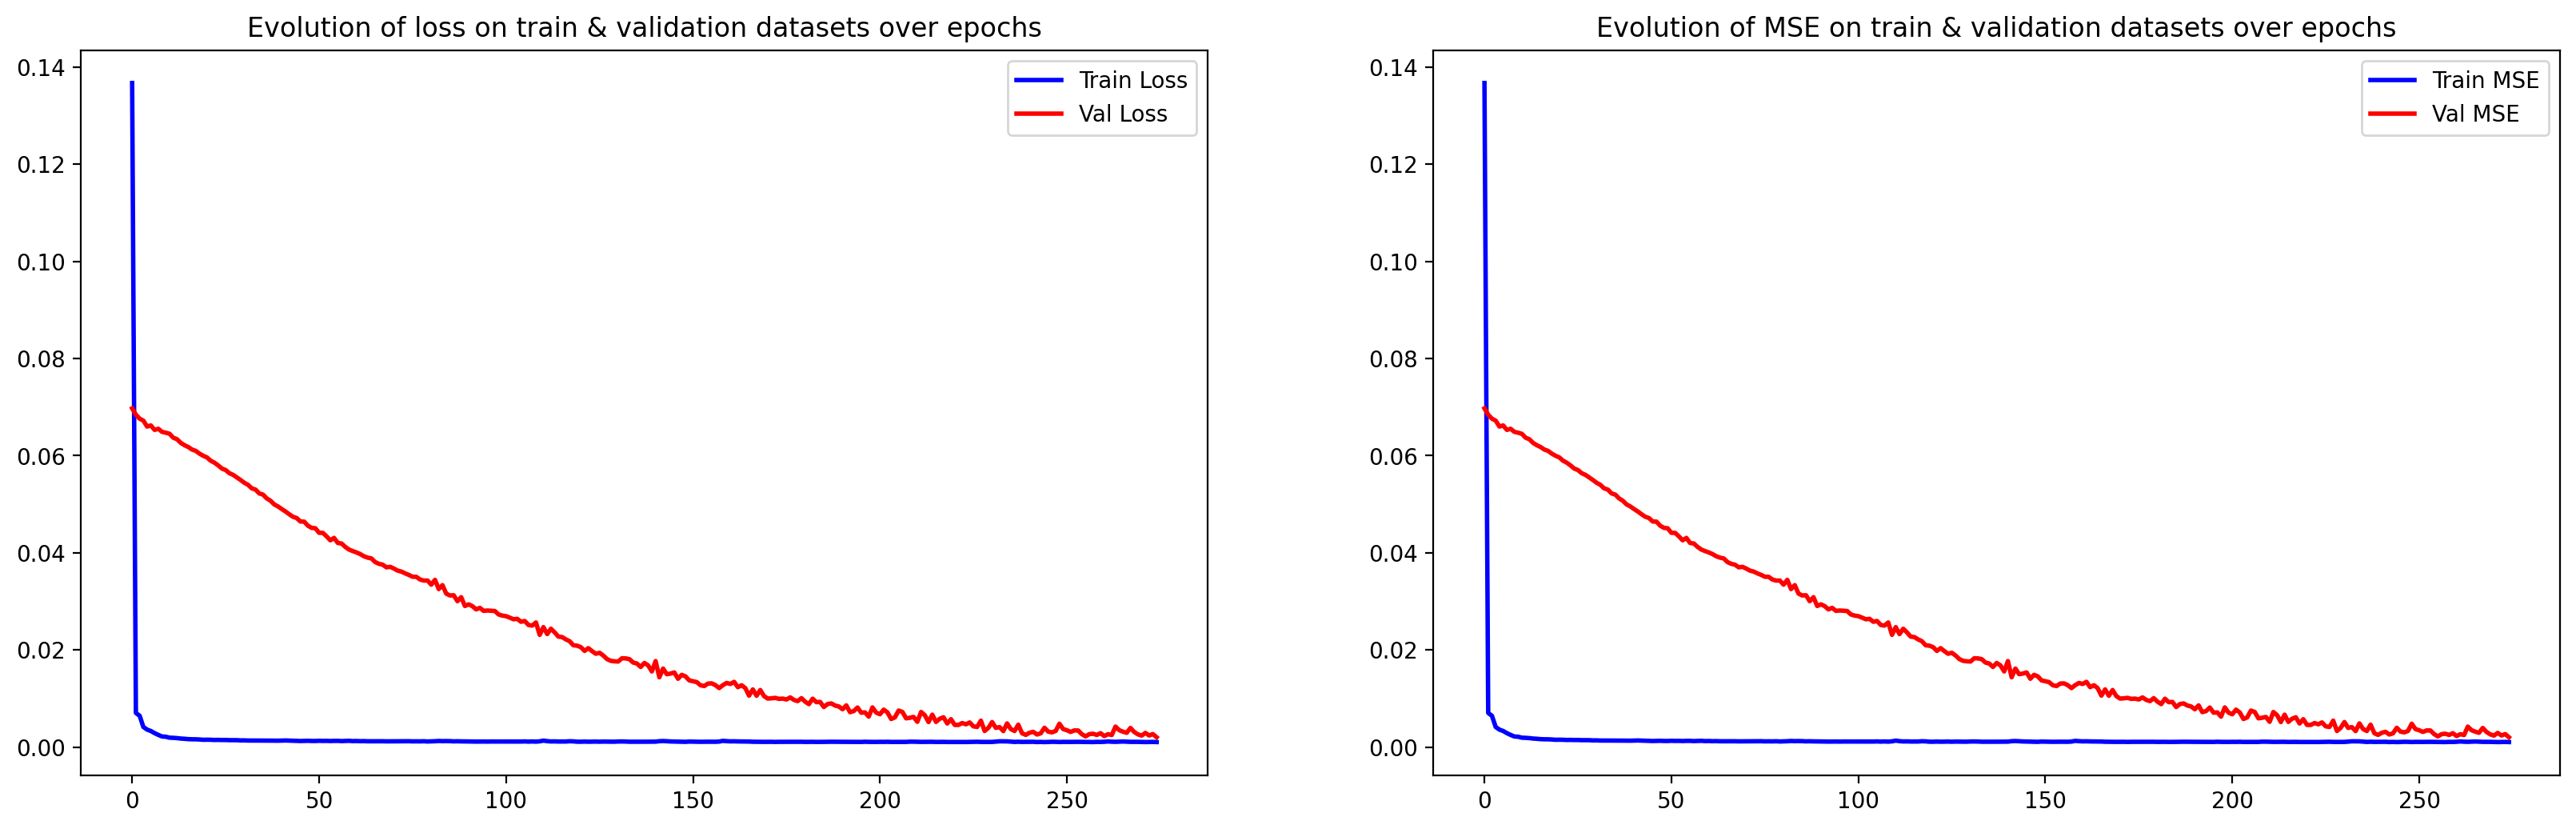

In [595]:
# Check how loss & mae went down
epoch_loss = history_LSTM.history['loss']
epoch_val_loss = history_LSTM.history['val_loss']
epoch_mse = history_LSTM.history['mse']
epoch_val_mse = history_LSTM.history['val_mse']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mse)), epoch_val_mse, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [573]:
GSPC_test = pd.read_csv('GSPC_index_close_test123.csv')
GSPC_test['Date']=pd.to_datetime(GSPC_test['Date'])
GSPC_test.set_index('Date', inplace=True)
GSPC_test

Close
Date                   
2017-01-03  2257.830078
2017-01-04  2270.750000
2017-01-05  2269.000000
2017-01-06  2276.979980
2017-01-09  2268.899902
...                 ...
2018-12-24  2351.100098
2018-12-26  2467.699951
2018-12-27  2488.830078
2018-12-28  2485.739990
2018-12-31  2506.850098

[502 rows x 1 columns]

1/1 [==============================] - 0s 57ms/step


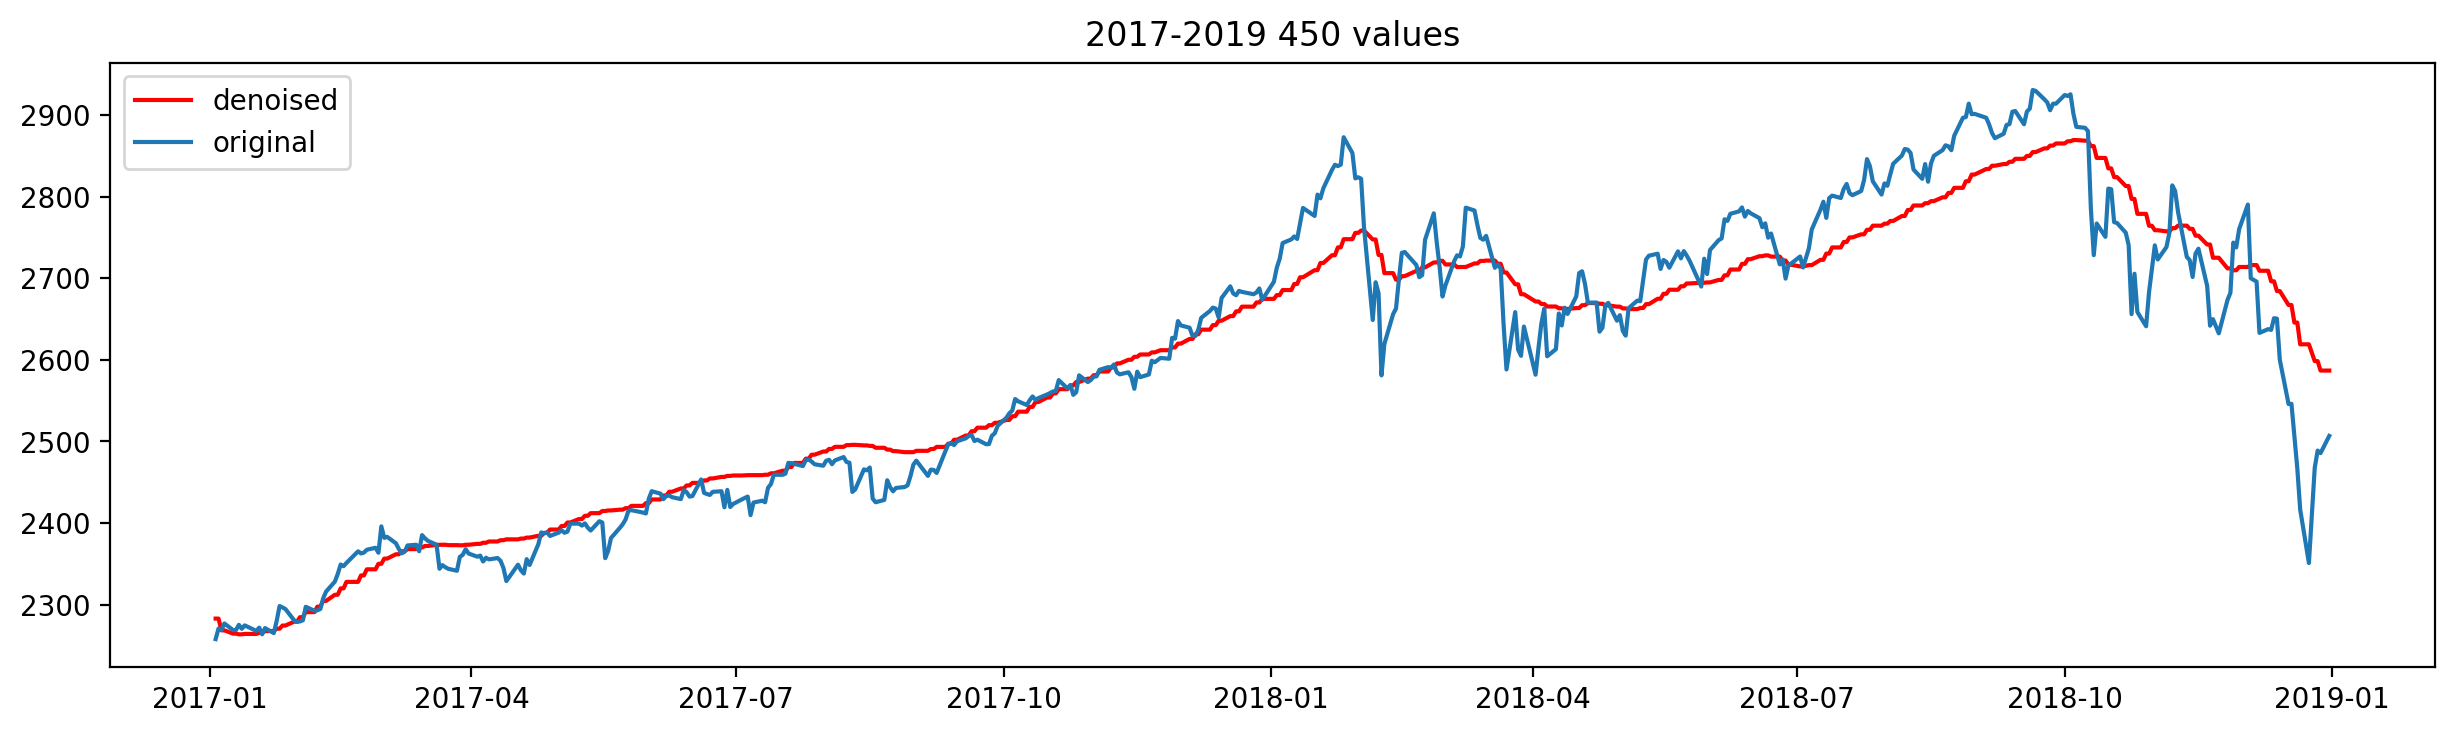

In [593]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_lstm = modelen_LSTM.predict(noise_mm_T.T, batch_size=16)
Y_test_mm_lstm=Y_test_mm_lstm.reshape((502,1))
pure_mm_lstm = mm_t.inverse_transform(Y_test_mm_lstm)
pure_mm_lstm=pd.DataFrame(pure_mm_lstm,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_lstm,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 450 values')
plt.legend(['denoised', 'original'], loc='upper left')

In [582]:
def set_model_encoding_mm():
    model = Sequential()
    #encoding
    model.add(Conv1D(128, kernel_size=3, activation='elu', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(64, kernel_size=3,activation='elu',padding='same'))
    model.add(BatchNormalization())
    #Use the normalization preprocessing of the data as mentioned before, so that the input x does not vary too much
    model.add(MaxPooling1D(2, padding='same'))
    model.add(Dropout(0.2))
    #decoding
    model.add(Conv1D(64, kernel_size=3, activation='elu', padding='same'))
    model.add(Conv1D(128, kernel_size=3,activation='elu',padding='same'))
    model.add(BatchNormalization())
    model.add(UpSampling1D(2))
    
    model.add(Conv1D(1,kernel_size=2,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_75 (Conv1D)          (None, None, 128)         512       
                                                                 
 conv1d_76 (Conv1D)          (None, None, 64)          24640     
                                                                 
 batch_normalization_48 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, None, 64)          0         
                                                                 
 conv1d_77 (Conv1D)          (None, None, 64)        

In [ ]:
model = Sequential()
model.add(Conv1D(128, kernel_size=3, activation='elu', padding='same',input_shape=(None, 1)))
model.add(Conv1D(64, kernel_size=3,activation='elu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(128, kernel_size=3,activation='elu',padding='same'))
model.add(BatchNormalization())
model.add(UpSampling1D(2))

model.add(Conv1D(1,kernel_size=2,activation='sigmoid', padding='same'))
model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mse'])

In [583]:
callback = EarlyStopping(monitor='loss', patience=30)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
3/3 [==============================] - 2s 157ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 2/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0548 - val_mse: 0.0548
Epoch 3/400
3/3 [==============================] - 0s 73ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0561 - val_mse: 0.0561
Epoch 4/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 5/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 6/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0550 - val_mse: 0.0550
Epoch 7/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0567 - val_mse: 0.0567
Epoch 8/400
3/3 [==============================] - 0s 74ms/step - loss: 0.0041 - mse: 0.0

3/3 [==============================] - 0s 72ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 64/400
3/3 [==============================] - 0s 71ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0396 - val_mse: 0.0396
Epoch 65/400
3/3 [==============================] - 0s 73ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0392 - val_mse: 0.0392
Epoch 66/400
3/3 [==============================] - 0s 87ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0397 - val_mse: 0.0397
Epoch 67/400
3/3 [==============================] - 0s 76ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 68/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 69/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 70/400
3/3 [==============================] - 0s 71ms/step - loss: 0.0018 - mse: 0.0018 - 

3/3 [==============================] - 0s 72ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 126/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 127/400
3/3 [==============================] - 0s 72ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 128/400
3/3 [==============================] - 0s 71ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 129/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 130/400
3/3 [==============================] - 0s 79ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 131/400
3/3 [==============================] - 0s 79ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 132/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0016 - mse: 0.

3/3 [==============================] - 0s 77ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 188/400
3/3 [==============================] - 0s 78ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 189/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 190/400
3/3 [==============================] - 0s 79ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 191/400
3/3 [==============================] - 0s 78ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 192/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 193/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 194/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0015 - mse: 0.

3/3 [==============================] - 0s 81ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 250/400
3/3 [==============================] - 0s 81ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 251/400
3/3 [==============================] - 0s 85ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 252/400
3/3 [==============================] - 0s 78ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 253/400
3/3 [==============================] - 0s 87ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 254/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 255/400
3/3 [==============================] - 0s 78ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 256/400
3/3 [==============================] - 0s 86ms/step - loss: 0.0013 - mse: 0.

3/3 [==============================] - 0s 78ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 312/400
3/3 [==============================] - 0s 78ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 313/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 314/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 315/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 316/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 317/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 318/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.

3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 374/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 375/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 376/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 377/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 378/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 379/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 380/400
3/3 [==============================] - 0s 77ms/step - loss: 0.0013 - mse: 0.

In [571]:
modelen_mm.save_weights('model_weights_mm.h5', overwrite=True)  

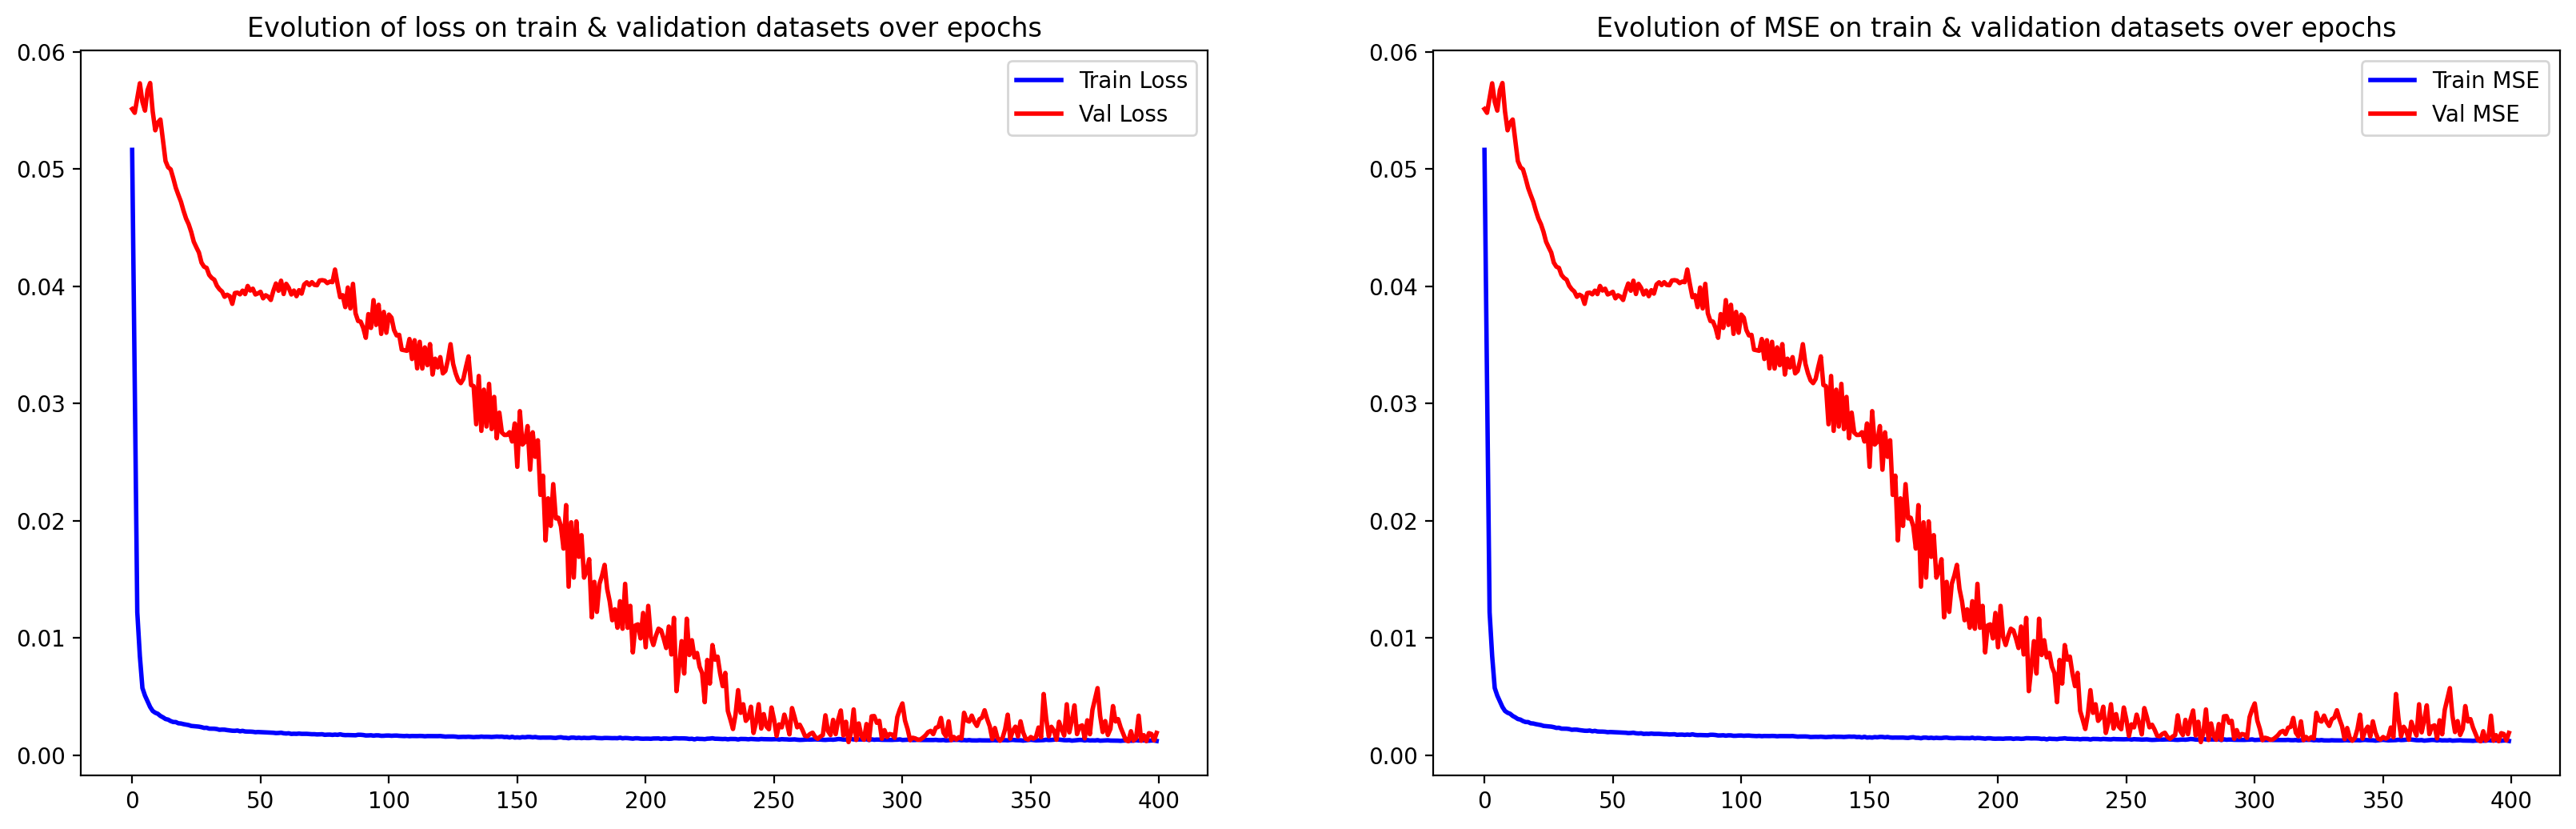

In [591]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']
epoch_mse = history_mm.history['mse']
epoch_val_mse = history_mm.history['val_mse']

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mse)), epoch_mse, 'b-', linewidth=2, label='Train MSE')
plt.plot(range(0,len(epoch_val_mse)), epoch_val_mse, 'r-', linewidth=2,label='Val MSE')
plt.title('Evolution of MSE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [18]:
modelen_mm.load_weights('model_weights_mm.h5') 

1/1 [==============================] - 0s 16ms/step


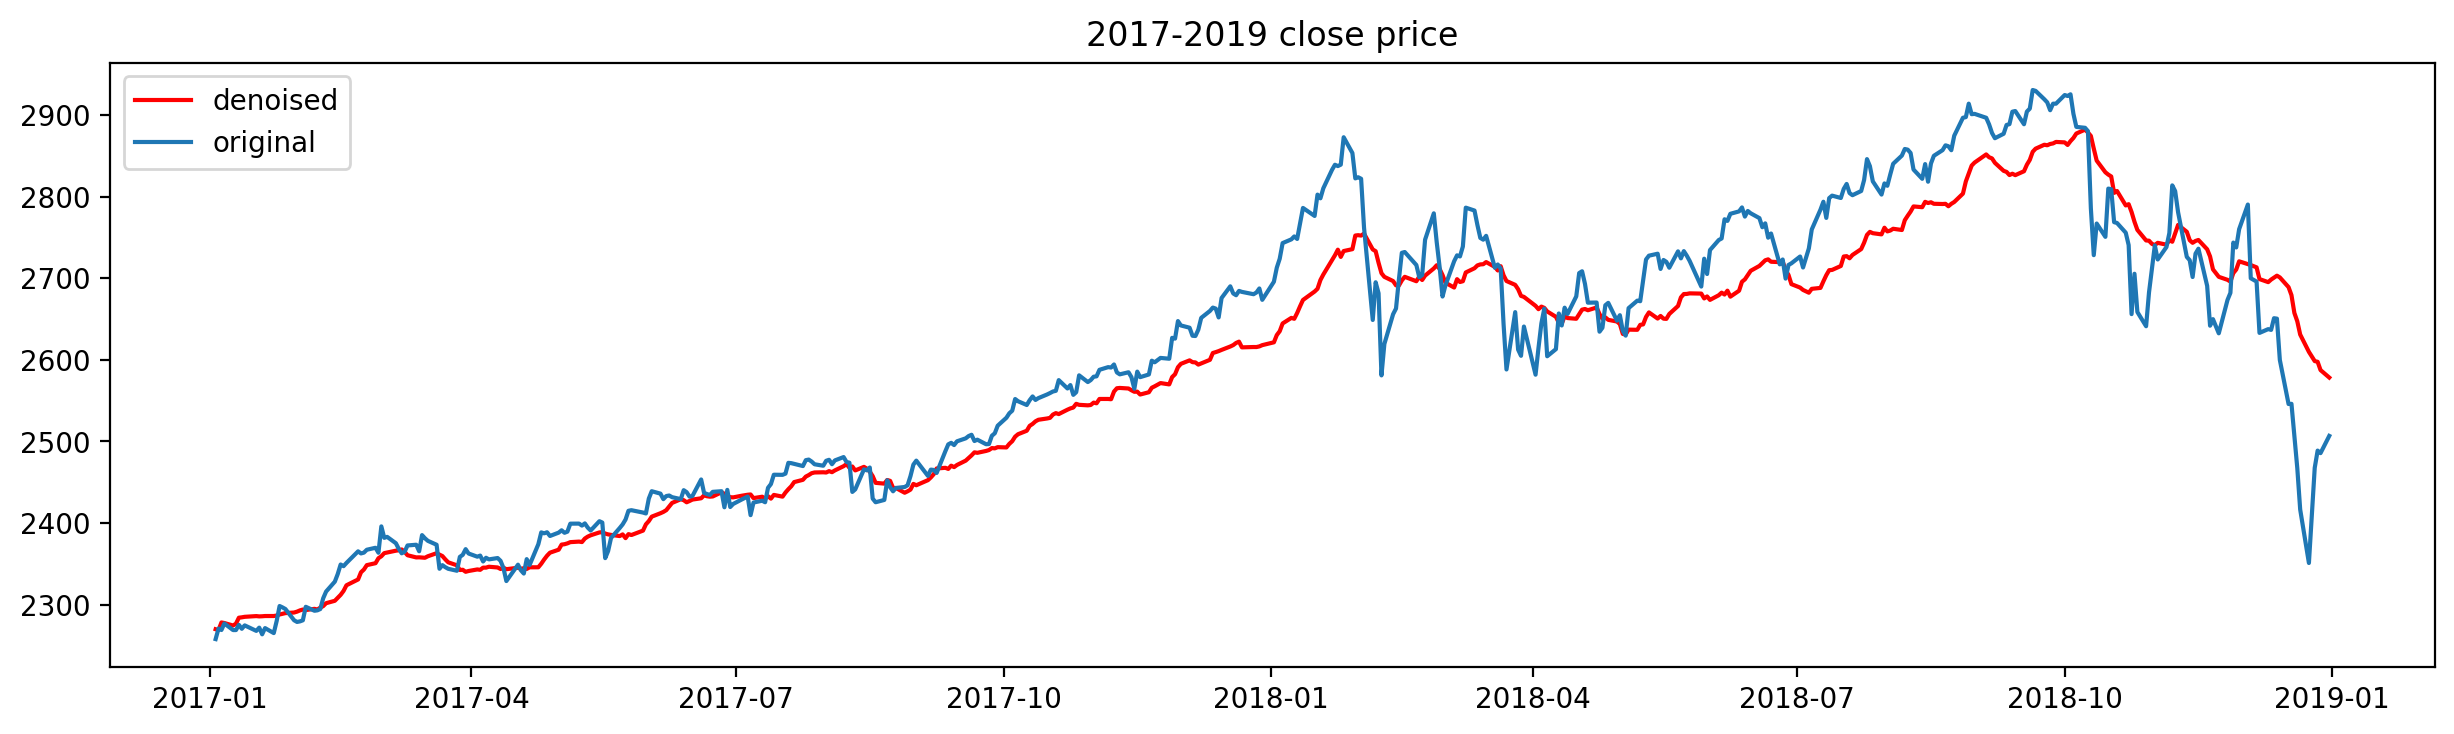

In [590]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(GSPC_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T, batch_size=8)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((502,1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['Close'],index=GSPC_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn,'r')
plt.plot(GSPC_test)
plt.title('2017-2019 close price')
plt.legend(['denoised', 'original'], loc='upper left')

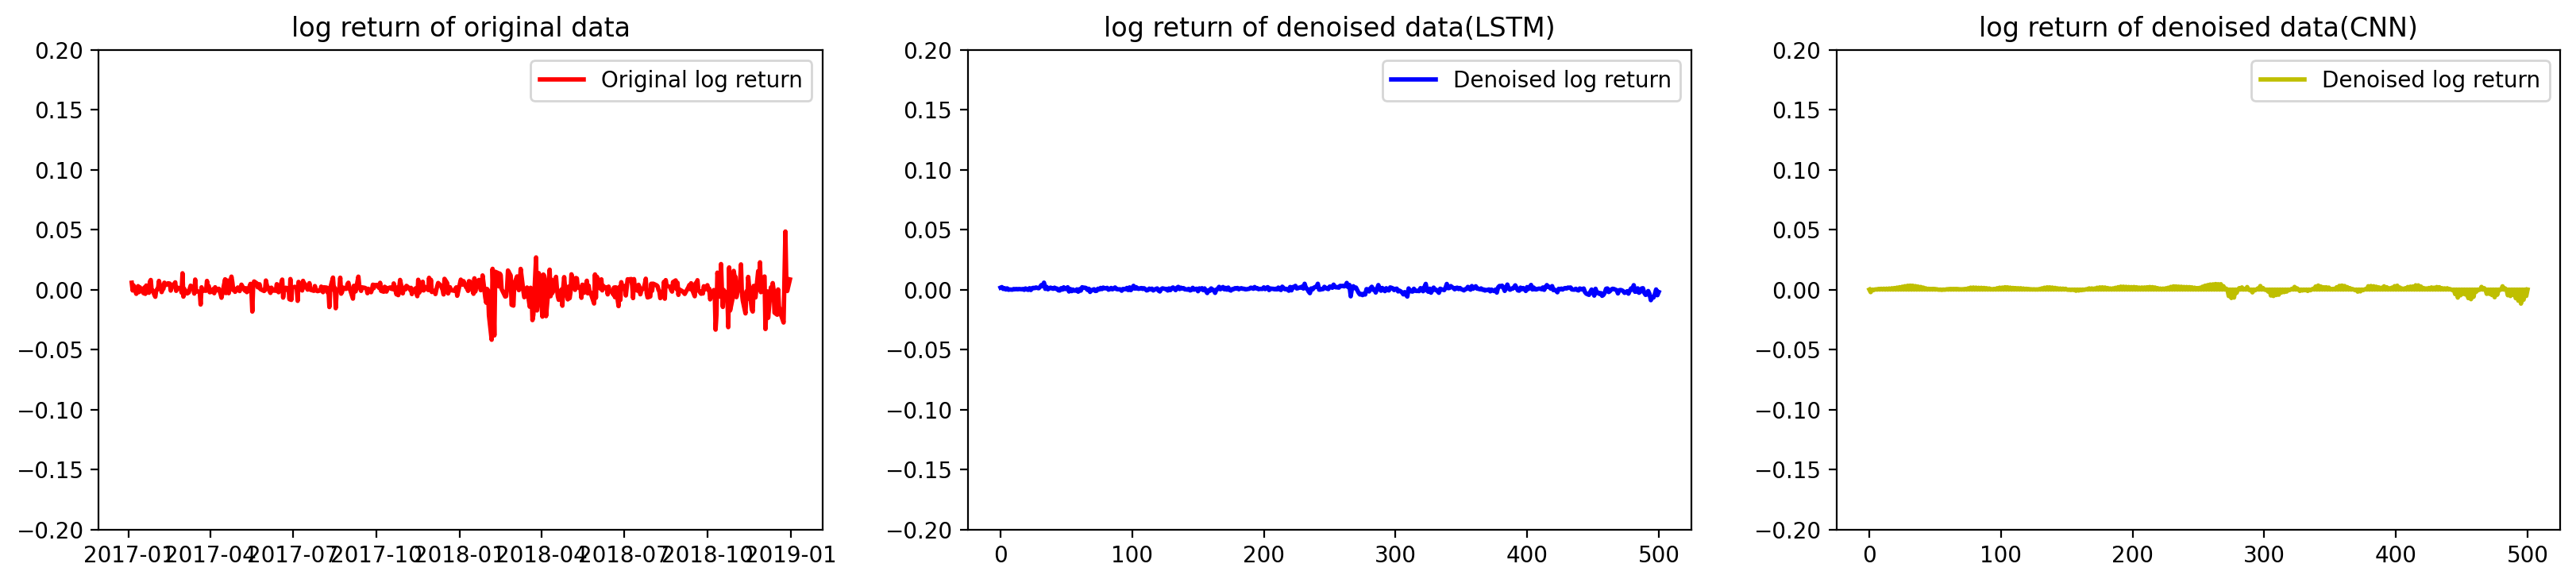

In [598]:
# Log Returns
GSPC_test['log_ret'] = np.log(GSPC_test.iloc[:,0]).diff()
pure_mm_lstm['log_ret'] = np.log(pure_mm_lstm.iloc[:,0]).diff()
pure_mm_cnn['log_ret'] = np.log(pure_mm_cnn.iloc[:,0]).diff()


plt.figure(figsize=(20,4),dpi=200)
plt.subplot(1,3,1)
plt.plot(GSPC_test['log_ret'], 'r-', linewidth=2, label='Original log return')
plt.ylim(-0.2,0.2)
plt.title('log return of original data')
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.plot(d_cnn, 'b-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(LSTM)')
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.plot(d_lstm, 'y-', linewidth=2, label='Denoised log return')
plt.ylim(-0.2,0.2)
plt.title('log return of denoised data(CNN)')
plt.legend(loc='best')

plt.show()

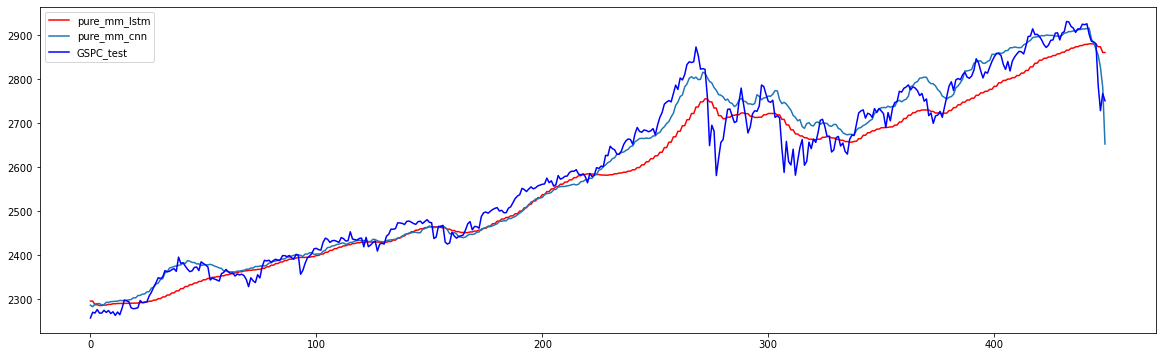

In [90]:
plt.figure(figsize=(20,6))
plt.plot(pure_mm_lstm,'r-',label='pure_mm_lstm')
plt.plot(pure_mm_cnn,label='pure_mm_cnn')
plt.plot(GSPC_test,'b-',label='GSPC_test')
plt.legend()

In [651]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

In [658]:
def svmf1(dataset,long_predict=10):
    f1=np.empty(0)
    for n in np.arange(0.0, 0.04, 0.0005):#get multiple threshold
        threshold = n
        daily_label=np.empty(0)#make the data labelled
        for i in range(0,len(dataset)):
            if dataset.iloc[i,1]<-threshold:
                n=-1
                daily_label=np.append(daily_label,n)
            elif abs(dataset.iloc[i,1])<=threshold:
                n=0
                daily_label=np.append(daily_label,n)
            else:
                n=1
                daily_label=np.append(daily_label,n)
        X=pd.DataFrame()
        Y=pd.DataFrame()
        for i in range(1,len(dataset)-long_predict):
            X=pd.concat([X, pd.DataFrame(dataset.iloc[:,1].values[i:i+long_predict]).T],ignore_index=True)#n values of log return to predict trends
            Y=pd.concat([Y, pd.DataFrame(daily_label[i+long_predict:i+long_predict+1]).T],ignore_index=True)#labels of trends
        X=np.array(X)
        Y=np.array(Y[0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
        svc_rbf = SVC(kernel='rbf',decision_function_shape='ovo')
        f1=np.append(f1,cross_val_score(svc_rbf , X_train, Y_train, scoring='f1_micro',cv=5,error_score=1).mean())
    return f1

In [659]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_cnn)

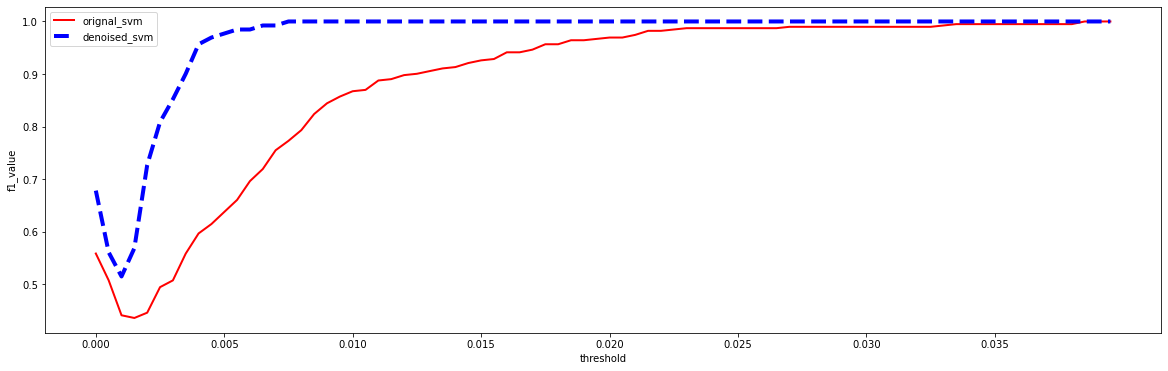

In [662]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.04, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.04, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.04, 0.005))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## LSTM

In [664]:
orignal_svm=svmf1(GSPC_test)
denoised_svm=svmf1(pure_mm_lstm)

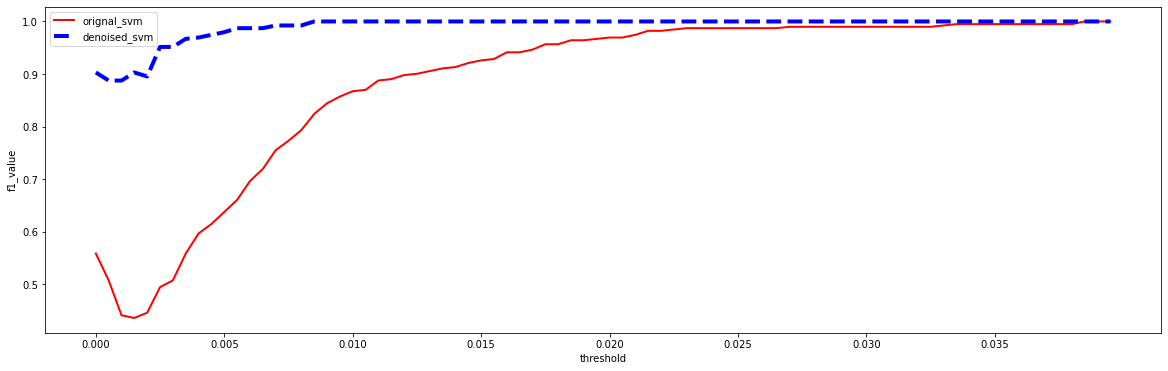

In [665]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0.0, 0.04, 0.0005),orignal_svm,label='orignal_svm', color='red', linewidth=2.0)
plt.plot(np.arange(0.0, 0.04, 0.0005),denoised_svm,label='denoised_svm', color='blue', linewidth=4.0, linestyle='--')
plt.xticks(np.arange(0.0, 0.04, 0.005))
plt.xlabel('threshold')
plt.ylabel('f1_value')
plt.legend()

## Bollinger band

In [680]:
def bbands(close_prices, window, no_of_stdev):#bollinger  bands, using today's closing price

    rolling_mean = close_prices.rolling(window,min_periods=1).mean()
    rolling_std = close_prices.rolling(window,min_periods=1).std()
    

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

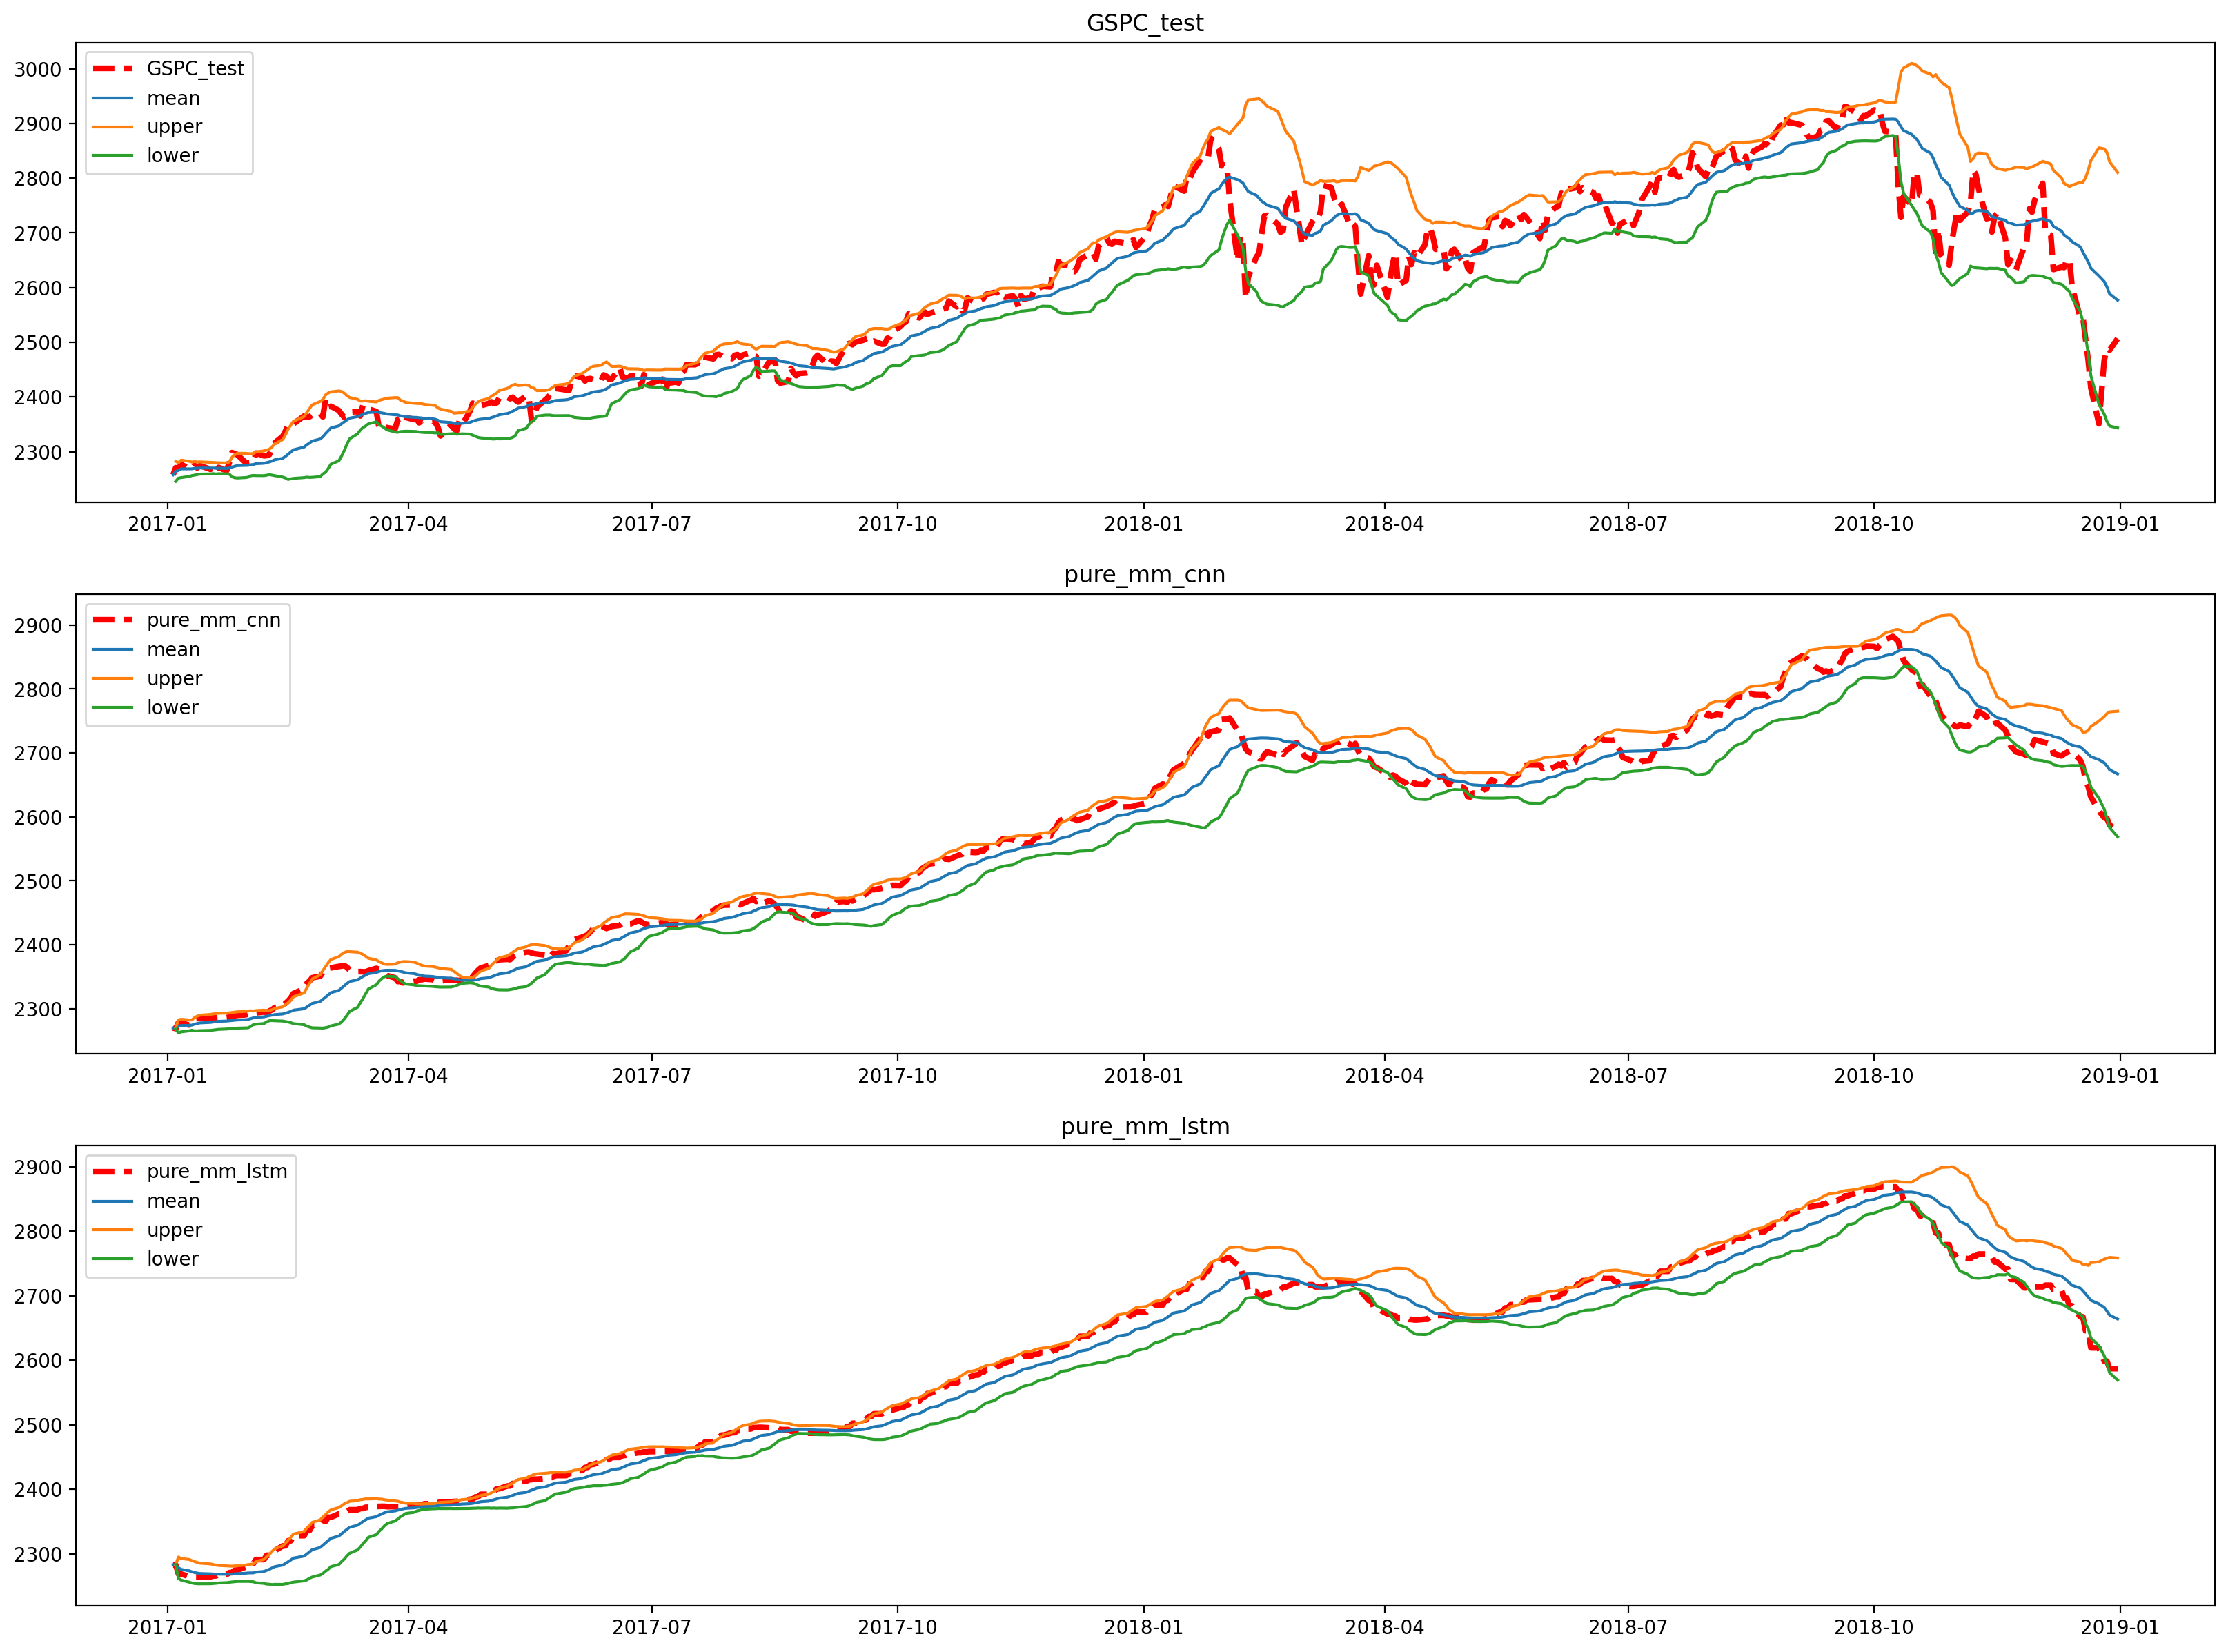

In [688]:
GSPC_test_bb=pd.DataFrame(columns=['mean','upper','lower'])
pure_mm_lstm_bb=pd.DataFrame(columns=['mean','upper','lower'])
pure_mm_cnn_bb=pd.DataFrame(columns=['mean','upper','lower'])
GSPC_test_bb['mean'],GSPC_test_bb['upper'],GSPC_test_bb['lower']=bbands(GSPC_test['Close'],20,2)
pure_mm_cnn_bb['mean'],pure_mm_cnn_bb['upper'],pure_mm_cnn_bb['lower']=bbands(pure_mm_cnn['Close'],20,2)
pure_mm_lstm_bb['mean'],pure_mm_lstm_bb['upper'],pure_mm_lstm_bb['lower']=bbands(pure_mm_lstm['Close'],20,2)

plt.figure(figsize=(20,15),dpi=200)

plt.subplot(3,1,1)
plt.title('GSPC_test')
plt.plot(GSPC_test['Close'],label='GSPC_test', color='red', linewidth=3.0, linestyle='--')
plt.plot(GSPC_test_bb['mean'],label='mean')
plt.plot(GSPC_test_bb['upper'],label='upper')
plt.plot(GSPC_test_bb['lower'],label='lower')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.title('pure_mm_cnn')
plt.plot(pure_mm_cnn['Close'],label='pure_mm_cnn', color='red', linewidth=3.0, linestyle='--')
plt.plot(pure_mm_cnn_bb['mean'],label='mean')
plt.plot(pure_mm_cnn_bb['upper'],label='upper')
plt.plot(pure_mm_cnn_bb['lower'],label='lower')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.title('pure_mm_lstm')
plt.plot(pure_mm_lstm['Close'],label='pure_mm_lstm', color='red', linewidth=3.0, linestyle='--')
plt.plot(pure_mm_lstm_bb['mean'],label='mean')
plt.plot(pure_mm_lstm_bb['upper'],label='upper')
plt.plot(pure_mm_lstm_bb['lower'],label='lower')
plt.legend(loc='best')

In [715]:
def buy_signal_function(dataset,dataset1,dataset2,dataset3):
    buy_signal=pd.DataFrame(columns=['Price'],index=dataset.index)
    buy_signal['Price']=dataset['Close']
    buy_signal['GSPC_test']=dataset1['Close']
    buy_signal['pure_mm_cnn']=dataset2['Close']
    buy_signal['pure_mm_lstm']=dataset3['Close']
    buy_signal['mean'],buy_signal['upper'],buy_signal['lower']=bbands(dataset['Close'],20,2)
    buy_signal['side'] = np.nan 
    buy_signal['signal'] = np.nan 
    for i in range(0,len(dataset)):
        if (buy_signal.iloc[i,0]<buy_signal.iloc[i,6]):
            buy_signal.iloc[i,7]=1
            if (buy_signal.iloc[i-1,0]>=buy_signal.iloc[i-1,6]):
                buy_signal.iloc[i,8]=1
        elif (buy_signal.iloc[i,0]>buy_signal.iloc[i,5]):
            buy_signal.iloc[i,7]=-1
            if (buy_signal.iloc[i-1,0]<=buy_signal.iloc[i-1,5]):
                buy_signal.iloc[i,8]=-1
    return buy_signal

In [718]:
GSPC_test_signal=buy_signal_function(GSPC_test,GSPC_test,pure_mm_cnn,pure_mm_lstm)
GSPC_test_signal

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-01-03  2257.830078  2257.830078  2269.933350   2282.966553  2257.830078   
2017-01-04  2270.750000  2270.750000  2268.900391   2282.966553  2264.290039   
2017-01-05  2269.000000  2269.000000  2278.229492   2268.530029  2265.860026   
2017-01-06  2276.979980  2276.979980  2277.542480   2268.530029  2268.640015   
2017-01-09  2268.899902  2268.899902  2274.477539   2264.520752  2268.691992   
...                 ...          ...          ...           ...          ...   
2018-12-24  2351.100098  2351.100098  2609.819580   2619.093750  2621.355005   
2018-12-26  2467.699951  2467.699951  2598.546143   2598.544434  2611.067505   
2018-12-27  2488.830078  2488.830078  2597.668701   2598.544434  2601.400513   
2018-12-28  2485.739990  2485.739990  2587.520020   2586.926758  2588.498010   
2018-12-31  2506.850098  2506.850098  2578.353271   2586.926758  2576.950513   

                  upper        lower  side  signal  
Date                                                
2017-01-03          NaN          NaN   NaN     NaN  
2017-01-04  2282.561568  2246.018510   NaN     NaN  
2017-01-05  2279.877968  2251.842084   NaN     NaN  
2017-01-06  2284.597934  2252.682096   NaN     NaN  
2017-01-09  2282.513910  2254.870074   NaN     NaN  
...                 ...          ...   ...     ...  
2018-12-24  2855.525843  2387.184167   1.0     NaN  
2018-12-26  2853.533021  2368.601989   NaN     NaN  
2018-12-27  2847.322054  2355.478972   NaN     NaN  
2018-12-28  2830.002400  2346.993621   NaN     NaN  
2018-12-31  2810.346110  2343.554916   NaN     NaN  

[502 rows x 9 columns]

In [722]:
GSPC_test_signal[~np.isnan(GSPC_test_signal['signal'])]

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-01-25  2298.370117  2298.370117  2287.995850   2270.605469  2271.948730   
2017-02-10  2316.100098  2316.100098  2301.834229   2304.662842  2285.315002   
2017-02-21  2365.379883  2365.379883  2330.917969   2327.954102  2308.526013   
2017-03-21  2344.020020  2344.020020  2361.340332   2373.344971  2371.690503   
2017-04-13  2328.949951  2328.949951  2343.481934   2380.073730  2354.799988   
2017-04-25  2388.610107  2388.610107  2350.198730   2384.446533  2355.846985   
2017-06-02  2439.070068  2439.070068  2407.886475   2428.961914  2400.479480   
2017-06-29  2419.699951  2419.699951  2431.749023   2457.827148  2434.710498   
2017-07-06  2409.750000  2409.750000  2435.085938   2458.734131  2432.563989   
2017-07-14  2459.270020  2459.270020  2434.531738   2461.019531  2433.704492   
2017-07-19  2473.830078  2473.830078  2441.527832   2468.632568  2437.201501   
2017-08-10  2438.209961  2438.209961  2469.346924   2495.896729  2470.625000   
2017-08-17  2430.010010  2430.010010  2457.577881   2494.600342  2467.804517   
2017-09-12  2496.479980  2496.479980  2466.389404   2497.329834  2456.303040   
2017-10-05  2552.070068  2552.070068  2505.931885   2530.972656  2507.264539   
2017-10-27  2581.070068  2581.070068  2544.938721   2572.898193  2555.292493   
2017-11-28  2627.040039  2627.040039  2578.979492   2615.273926  2588.366516   
2018-01-04  2723.989990  2723.989990  2635.150391   2679.427246  2675.422034   
2018-01-12  2786.239990  2786.239990  2673.439697   2701.252930  2707.396021   
2018-02-05  2648.939941  2648.939941  2735.354736   2747.578125  2797.145996   
2018-02-08  2581.000000  2581.000000  2706.235107   2728.607666  2782.674487   
2018-03-22  2643.689941  2643.689941  2703.642578   2707.142334  2731.898010   
2018-05-10  2723.070068  2723.070068  2652.638184   2668.351318  2669.530969   
2018-06-06  2772.350098  2772.350098  2680.092041   2703.672607  2725.366516   
2018-06-27  2699.629883  2699.629883  2709.966309   2721.807129  2755.600024   
2018-08-27  2896.739990  2896.739990  2803.777344   2810.855957  2846.597498   
2018-09-20  2930.750000  2930.750000  2855.072754   2854.658936  2893.628979   
2018-10-10  2785.679932  2785.679932  2874.490723   2862.005371  2902.534009   
2018-10-24  2656.100098  2656.100098  2781.267578   2797.266602  2824.689502   
2018-12-17  2545.939941  2545.939941  2689.143799   2667.272217  2674.510999   
2018-12-19  2506.959961  2506.959961  2657.539307   2645.756104  2655.816992   

                  upper        lower  side  signal  
Date                                                
2017-01-25  2289.604265  2254.293196  -1.0    -1.0  
2017-02-10  2314.329356  2256.300649  -1.0    -1.0  
2017-02-21  2364.342178  2252.709848  -1.0    -1.0  
2017-03-21  2393.846709  2349.534297   1.0     1.0  
2017-04-13  2377.951972  2331.648003   1.0     1.0  
2017-04-25  2381.494294  2330.199675  -1.0    -1.0  
2017-06-02  2438.181073  2362.777886  -1.0    -1.0  
2017-06-29  2449.404040  2420.016956   1.0     1.0  
2017-07-06  2451.308585  2413.819393   1.0     1.0  
2017-07-14  2457.687958  2409.721026  -1.0    -1.0  
2017-07-19  2469.862243  2404.540760  -1.0    -1.0  
2017-08-10  2490.153272  2451.096728   1.0     1.0  
2017-08-17  2496.262010  2439.347023   1.0     1.0  
2017-09-12  2494.627262  2417.978817  -1.0    -1.0  
2017-10-05  2546.911139  2467.617938  -1.0    -1.0  
2017-10-27  2580.859047  2529.725938  -1.0    -1.0  
2017-11-28  2614.652189  2562.080843  -1.0    -1.0  
2018-01-04  2721.502472  2629.341595  -1.0    -1.0  
2018-01-12  2782.193763  2632.598278  -1.0    -1.0  
2018-02-05  2898.804143  2695.487849   1.0     1.0  
2018-02-08  2933.756001  2631.592973   1.0     1.0  
2018-03-22  2803.319224  2660.476797   1.0     1.0  
2018-05-10  2721.754235  2617.307704  -1.0    -1.0  
2018-06-06  2761.762875  2688.970158  -1.0    -1.0  

In [724]:
GSPC_test_signal[GSPC_test_signal['signal']==1.0]

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-03-21  2344.020020  2344.020020  2361.340332   2373.344971  2371.690503   
2017-04-13  2328.949951  2328.949951  2343.481934   2380.073730  2354.799988   
2017-06-29  2419.699951  2419.699951  2431.749023   2457.827148  2434.710498   
2017-07-06  2409.750000  2409.750000  2435.085938   2458.734131  2432.563989   
2017-08-10  2438.209961  2438.209961  2469.346924   2495.896729  2470.625000   
2017-08-17  2430.010010  2430.010010  2457.577881   2494.600342  2467.804517   
2018-02-05  2648.939941  2648.939941  2735.354736   2747.578125  2797.145996   
2018-02-08  2581.000000  2581.000000  2706.235107   2728.607666  2782.674487   
2018-03-22  2643.689941  2643.689941  2703.642578   2707.142334  2731.898010   
2018-06-27  2699.629883  2699.629883  2709.966309   2721.807129  2755.600024   
2018-10-10  2785.679932  2785.679932  2874.490723   2862.005371  2902.534009   
2018-10-24  2656.100098  2656.100098  2781.267578   2797.266602  2824.689502   
2018-12-17  2545.939941  2545.939941  2689.143799   2667.272217  2674.510999   
2018-12-19  2506.959961  2506.959961  2657.539307   2645.756104  2655.816992   

                  upper        lower  side  signal  
Date                                                
2017-03-21  2393.846709  2349.534297   1.0     1.0  
2017-04-13  2377.951972  2331.648003   1.0     1.0  
2017-06-29  2449.404040  2420.016956   1.0     1.0  
2017-07-06  2451.308585  2413.819393   1.0     1.0  
2017-08-10  2490.153272  2451.096728   1.0     1.0  
2017-08-17  2496.262010  2439.347023   1.0     1.0  
2018-02-05  2898.804143  2695.487849   1.0     1.0  
2018-02-08  2933.756001  2631.592973   1.0     1.0  
2018-03-22  2803.319224  2660.476797   1.0     1.0  
2018-06-27  2809.395743  2701.804305   1.0     1.0  
2018-10-10  2965.285912  2839.782105   1.0     1.0  
2018-10-24  2989.320931  2660.058073   1.0     1.0  
2018-12-17  2792.343351  2556.678646   1.0     1.0  
2018-12-19  2800.499587  2511.134398   1.0     1.0

In [720]:
pure_mm_cnn_signal=buy_signal_function(pure_mm_cnn,GSPC_test,pure_mm_cnn,pure_mm_lstm)
pure_mm_cnn_signal

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-01-03  2269.933350  2257.830078  2269.933350   2282.966553  2269.933350   
2017-01-04  2268.900391  2270.750000  2268.900391   2282.966553  2269.416870   
2017-01-05  2278.229492  2269.000000  2278.229492   2268.530029  2272.354411   
2017-01-06  2277.542480  2276.979980  2277.542480   2268.530029  2273.651428   
2017-01-09  2274.477539  2268.899902  2274.477539   2264.520752  2273.816650   
...                 ...          ...          ...           ...          ...   
2018-12-24  2609.819580  2351.100098  2609.819580   2619.093750  2689.555383   
2018-12-26  2598.546143  2467.699951  2598.546143   2598.544434  2684.576648   
2018-12-27  2597.668701  2488.830078  2597.668701   2598.544434  2679.664368   
2018-12-28  2587.520020  2485.739990  2587.520020   2586.926758  2673.721265   
2018-12-31  2578.353271  2506.850098  2578.353271   2586.926758  2667.099524   

                  upper        lower  side  signal  
Date                                                
2017-01-03          NaN          NaN   NaN     NaN  
2017-01-04  2270.877695  2267.956046   NaN     NaN  
2017-01-05  2282.582644  2262.126178   NaN     NaN  
2017-01-06  2283.483039  2263.819818   NaN     NaN  
2017-01-09  2282.363076  2265.270225   NaN     NaN  
...                 ...          ...   ...     ...  
2018-12-24  2749.761105  2629.349662   1.0     NaN  
2018-12-26  2757.024118  2612.129178   1.0     NaN  
2018-12-27  2761.579419  2597.749316   1.0     NaN  
2018-12-28  2764.267205  2583.175324   NaN     NaN  
2018-12-31  2765.280185  2568.918863   NaN     NaN  

[502 rows x 9 columns]

In [725]:
pure_mm_cnn_signal[pure_mm_cnn_signal['signal']==1.0]

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-03-27  2348.254639  2341.590088  2348.254639   2372.981934  2359.984070   
2017-08-18  2449.331787  2425.550049  2449.331787   2492.304932  2462.813049   
2017-08-24  2443.124512  2438.969971  2443.124512   2488.183838  2461.118127   
2017-08-28  2437.210938  2444.239990  2437.210938   2486.907715  2458.912366   
2018-03-28  2678.442627  2605.000000  2678.442627   2680.464600  2703.160217   
2018-04-02  2666.256104  2581.879883  2666.256104   2671.564697  2700.404211   
2018-05-02  2631.843994  2635.669922  2631.843994   2663.090576  2652.827869   
2018-10-15  2829.917236  2750.790039  2829.917236   2847.529053  2861.904028   
2018-11-21  2710.928223  2649.929932  2710.928223   2725.195557  2745.691882   
2018-12-18  2679.340576  2546.159912  2679.340576   2667.272217  2706.020142   

                  upper        lower  side  signal  
Date                                                
2017-03-27  2369.771004  2350.197136   1.0     1.0  
2017-08-18  2474.279015  2451.347084   1.0     1.0  
2017-08-24  2477.254750  2444.981505   1.0     1.0  
2017-08-28  2479.626287  2438.198445   1.0     1.0  
2018-03-28  2726.930433  2679.390001   1.0     1.0  
2018-04-02  2731.159599  2669.648824   1.0     1.0  
2018-05-02  2669.059443  2636.596294   1.0     1.0  
2018-10-15  2889.053025  2834.755032   1.0     1.0  
2018-11-21  2771.188150  2720.195615   1.0     1.0  
2018-12-18  2732.440030  2679.600253   1.0     1.0

In [719]:
pure_mm_lstm_signal=buy_signal_function(pure_mm_lstm,GSPC_test,pure_mm_cnn,pure_mm_lstm)
pure_mm_lstm_signal

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2017-01-03  2282.966553  2257.830078  2269.933350   2282.966553  2282.966553   
2017-01-04  2282.966553  2270.750000  2268.900391   2282.966553  2282.966553   
2017-01-05  2268.530029  2269.000000  2278.229492   2268.530029  2278.154378   
2017-01-06  2268.530029  2276.979980  2277.542480   2268.530029  2275.748291   
2017-01-09  2264.520752  2268.899902  2274.477539   2264.520752  2273.502783   
...                 ...          ...          ...           ...          ...   
2018-12-24  2619.093750  2351.100098  2609.819580   2619.093750  2687.410229   
2018-12-26  2598.544434  2467.699951  2598.546143   2598.544434  2681.729419   
2018-12-27  2598.544434  2488.830078  2597.668701   2598.544434  2676.048608   
2018-12-28  2586.926758  2485.739990  2587.520020   2586.926758  2669.902795   
2018-12-31  2586.926758  2506.850098  2578.353271   2586.926758  2663.756982   

                  upper        lower  side  signal  
Date                                                
2017-01-03          NaN          NaN   NaN     NaN  
2017-01-04  2282.966553  2282.966553   NaN     NaN  
2017-01-05  2294.824240  2261.484517   NaN     NaN  
2017-01-06  2292.418152  2259.078430   NaN     NaN  
2017-01-09  2291.088553  2255.917013   NaN     NaN  
...                 ...          ...   ...     ...  
2018-12-24  2752.358385  2622.462074   1.0     NaN  
2018-12-26  2756.669203  2606.789635   1.0     NaN  
2018-12-27  2758.157796  2593.939421   NaN     NaN  
2018-12-28  2759.427077  2580.378514   NaN     NaN  
2018-12-31  2758.462861  2569.051104   NaN     NaN  

[502 rows x 9 columns]

In [764]:
pure_mm_lstm_signal[pure_mm_lstm_signal['signal']==1.0]

Price    GSPC_test  pure_mm_cnn  pure_mm_lstm         mean  \
Date                                                                           
2018-03-22  2707.142334  2643.689941  2703.642578   2707.142334  2717.473267   
2018-10-16  2834.706299  2809.919922  2827.065674   2834.706299  2859.963538   
2018-10-24  2797.266602  2656.100098  2781.267578   2797.266602  2848.248267   
2018-10-26  2778.990234  2658.689941  2759.299805   2778.990234  2840.667773   
2018-11-21  2725.195557  2649.929932  2710.928223   2725.195557  2760.118640   
2018-12-17  2667.272217  2545.939941  2689.143799   2667.272217  2711.833838   
2018-12-19  2645.756104  2506.959961  2657.539307   2645.756104  2702.802991   

                  upper        lower  side  signal  
Date                                                
2018-03-22  2725.178996  2709.767538   1.0     1.0  
2018-10-16  2878.543024  2841.384051   1.0     1.0  
2018-10-24  2894.789205  2801.707328   1.0     1.0  
2018-10-26  2898.778096  2782.557451   1.0     1.0  
2018-11-21  2789.964464  2730.272816   1.0     1.0  
2018-12-17  2752.320460  2671.347215   1.0     1.0  
2018-12-19  2748.685790  2656.920192   1.0     1.0

In [733]:
# Compute sides
print('GSPC_test_side:\n',GSPC_test_signal.side.value_counts(),'\n')
print('pure_mm_cnn_side:\n',pure_mm_cnn_signal.side.value_counts(),'\n')
print('pure_mm_lstm_side:\n',pure_mm_lstm_signal.side.value_counts(),'\n')

print('GSPC_test_signal:\n',GSPC_test_signal.signal.value_counts(),'\n')
print('pure_mm_cnn_signal:\n',pure_mm_cnn_signal.signal.value_counts(),'\n')
print('pure_mm_lstm_signal:\n',pure_mm_lstm_signal.signal.value_counts(),'\n')


GSPC_test_side:
 -1.0    32
 1.0    22
Name: side, dtype: int64 

pure_mm_cnn_side:
 -1.0    63
 1.0    30
Name: side, dtype: int64 

pure_mm_lstm_side:
 -1.0    42
 1.0    24
Name: side, dtype: int64 

GSPC_test_signal:
 -1.0    17
 1.0    14
Name: signal, dtype: int64 

pure_mm_cnn_signal:
 -1.0    13
 1.0    10
Name: signal, dtype: int64 

pure_mm_lstm_signal:
 -1.0    22
 1.0     7
Name: signal, dtype: int64 



In [766]:
GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index

DatetimeIndex(['2017-03-21', '2017-04-13', '2017-06-29', '2017-07-06',
               '2017-08-10', '2017-08-17', '2018-02-05', '2018-02-08',
               '2018-03-22', '2018-06-27', '2018-10-10', '2018-10-24',
               '2018-12-17', '2018-12-19'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [768]:
GSPC_test_signal.Price[GSPC_test_macd.signal == 1.0]

Date
2017-01-24    2280.070068
2017-01-25    2298.370117
2017-01-26    2296.679932
2017-01-27    2294.689941
2017-01-30    2280.899902
                 ...     
2018-10-03    2925.510010
2018-10-04    2901.610107
2018-10-05    2885.570068
2018-10-08    2884.429932
2018-10-09    2880.340088
Name: Price, Length: 354, dtype: float64

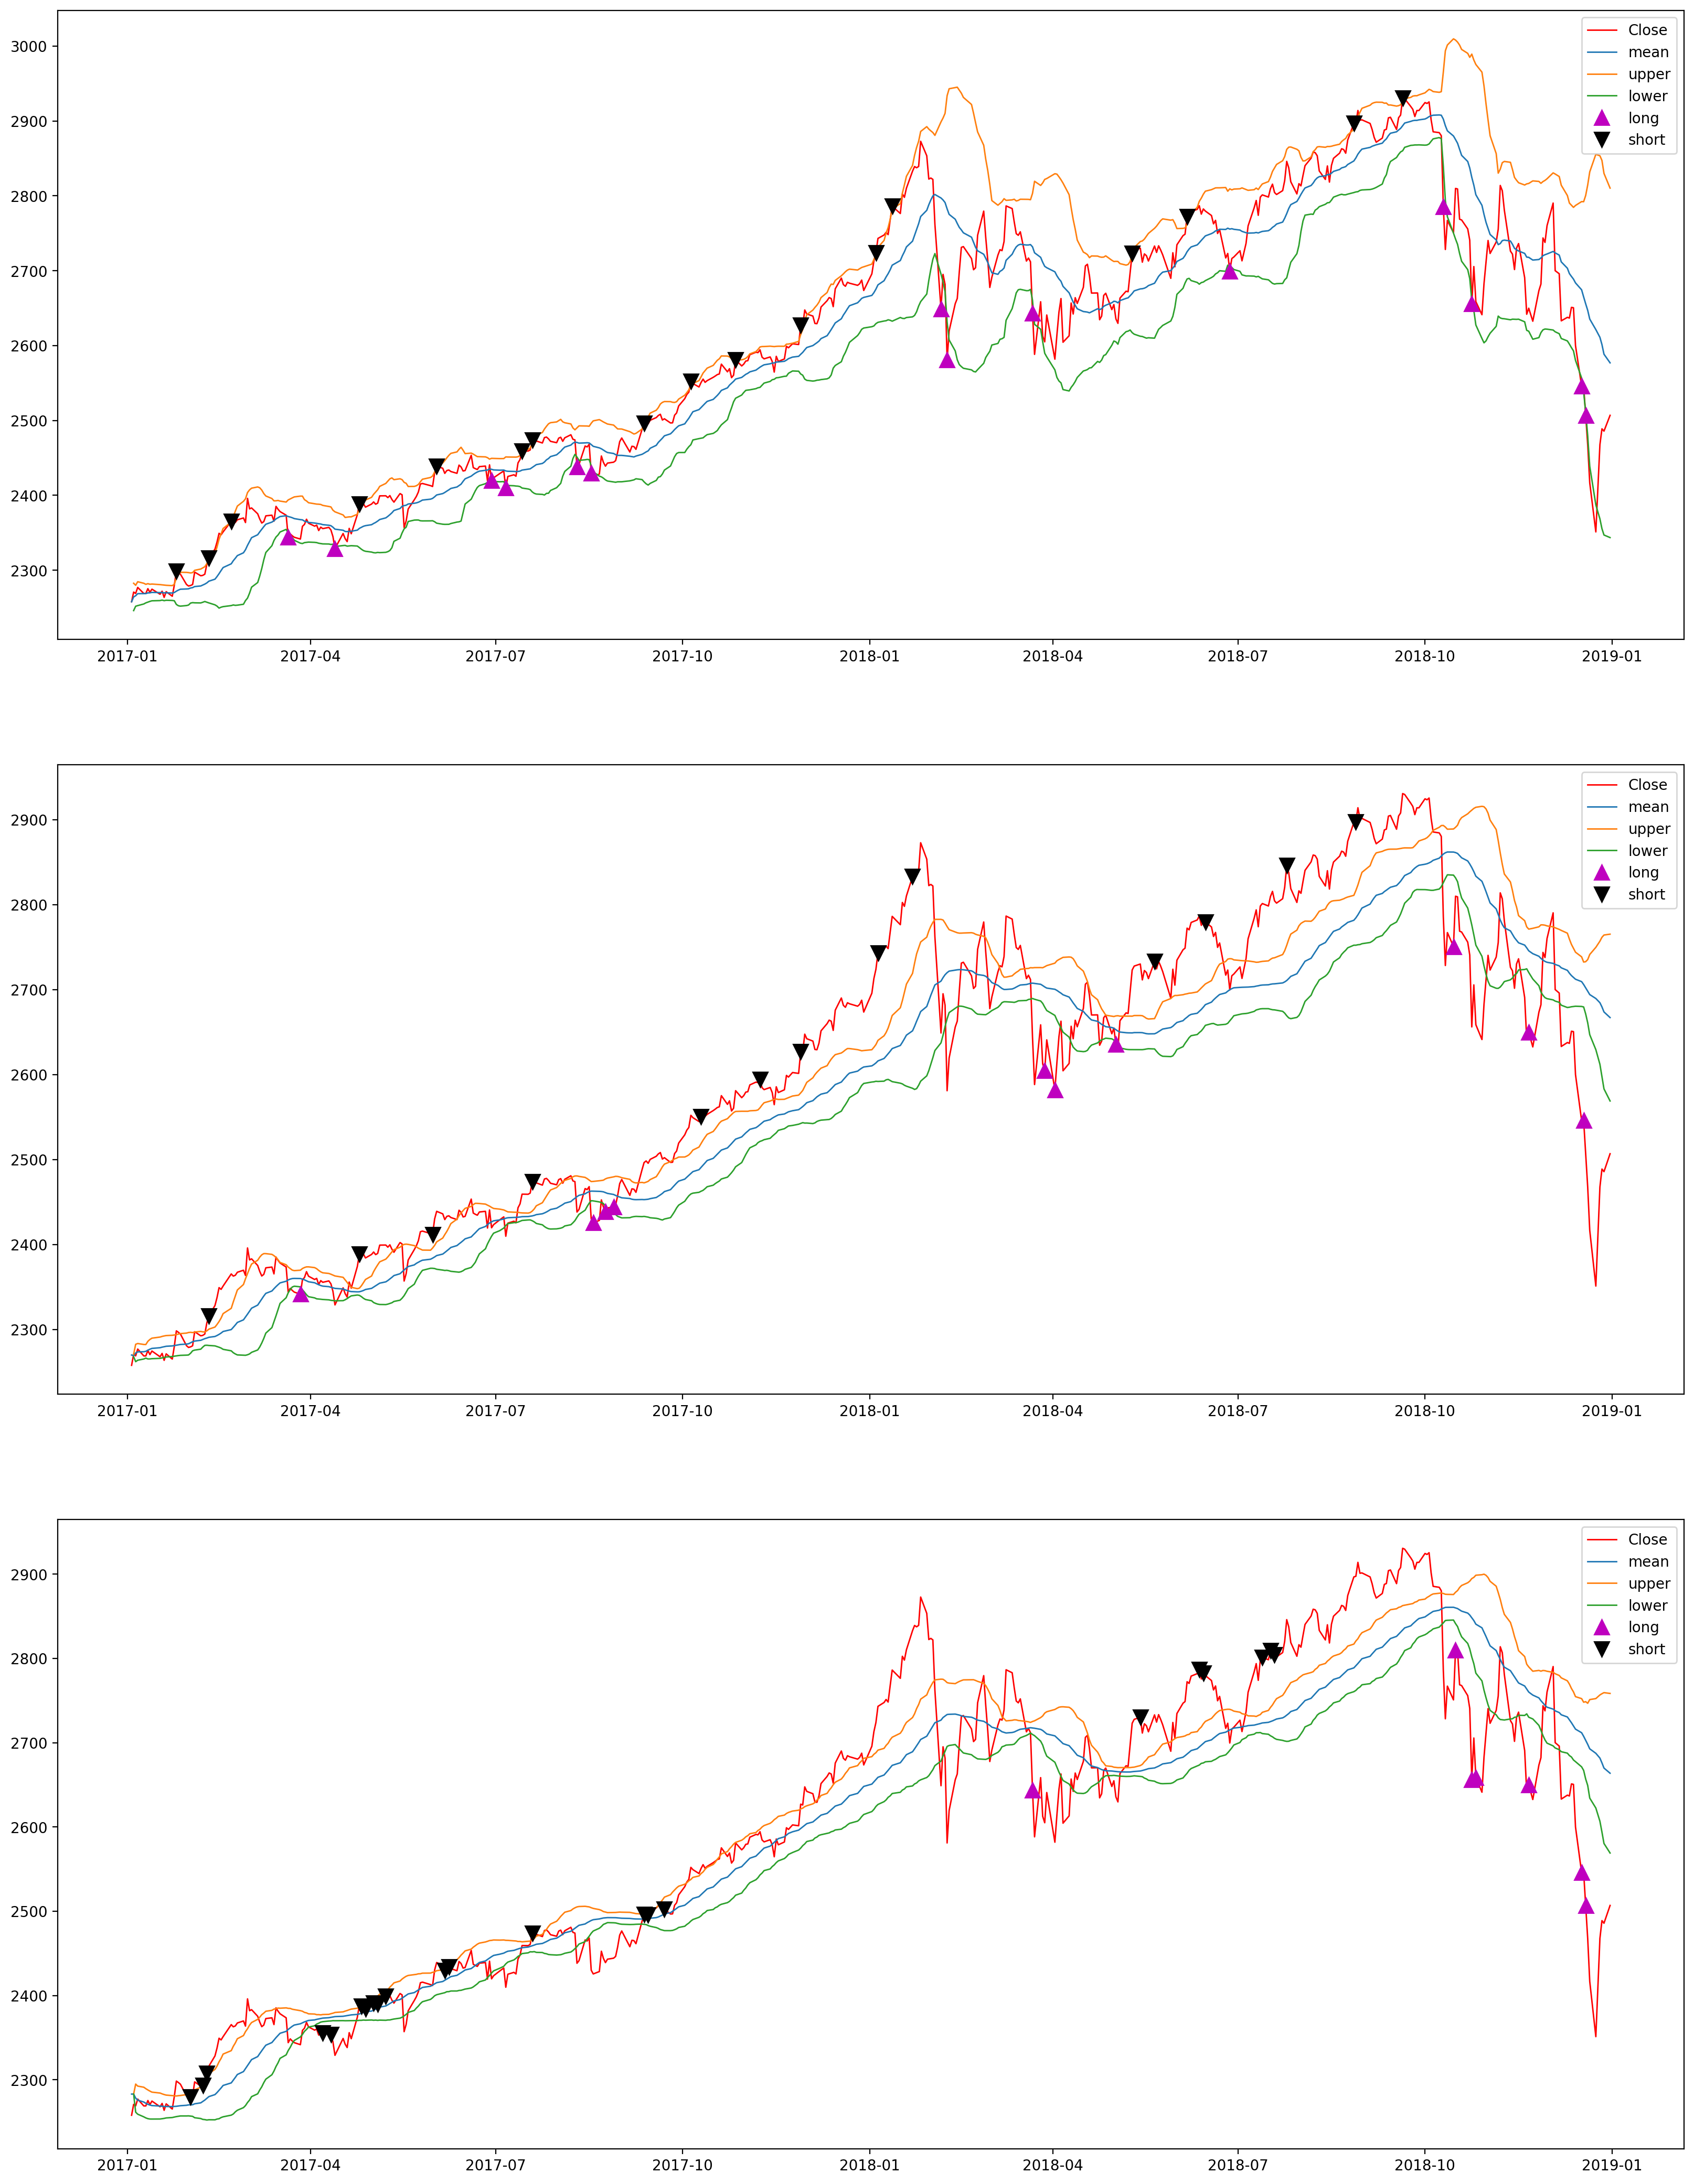

In [774]:
plt.figure(figsize=(20,27),dpi=200)
plt.subplot(3,1,1)
plt.plot(GSPC_test_signal['GSPC_test'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == 1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(GSPC_test_signal.loc[GSPC_test_signal.signal == -1.0].index, 
         GSPC_test_signal.Price[GSPC_test_signal.signal == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.plot(pure_mm_cnn_signal['GSPC_test'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == 1.0].index, 
         pure_mm_cnn_signal.GSPC_test[pure_mm_cnn_signal.signal == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_cnn_signal.loc[pure_mm_cnn_signal.signal == -1.0].index, 
         pure_mm_cnn_signal.GSPC_test[pure_mm_cnn_signal.signal == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()    

plt.subplot(3,1,3)
plt.plot(pure_mm_lstm_signal['GSPC_test'], color='r', lw=1,label='Close')
plt.plot(pure_mm_lstm_signal[['mean','upper','lower']], lw=1,label=['mean','upper','lower'])
plt.plot(pure_mm_lstm_signal.loc[pure_mm_lstm_signal.signal == 1.0].index, 
         pure_mm_lstm_signal.GSPC_test[pure_mm_lstm_signal.signal == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_lstm_signal.loc[pure_mm_lstm_signal.signal == -1.0].index, 
         pure_mm_lstm_signal.GSPC_test[pure_mm_lstm_signal.signal == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

## MACD

In [761]:
def MACD(dataset,short_window = 12,long_window = 26):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Close'].ewm(span=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals

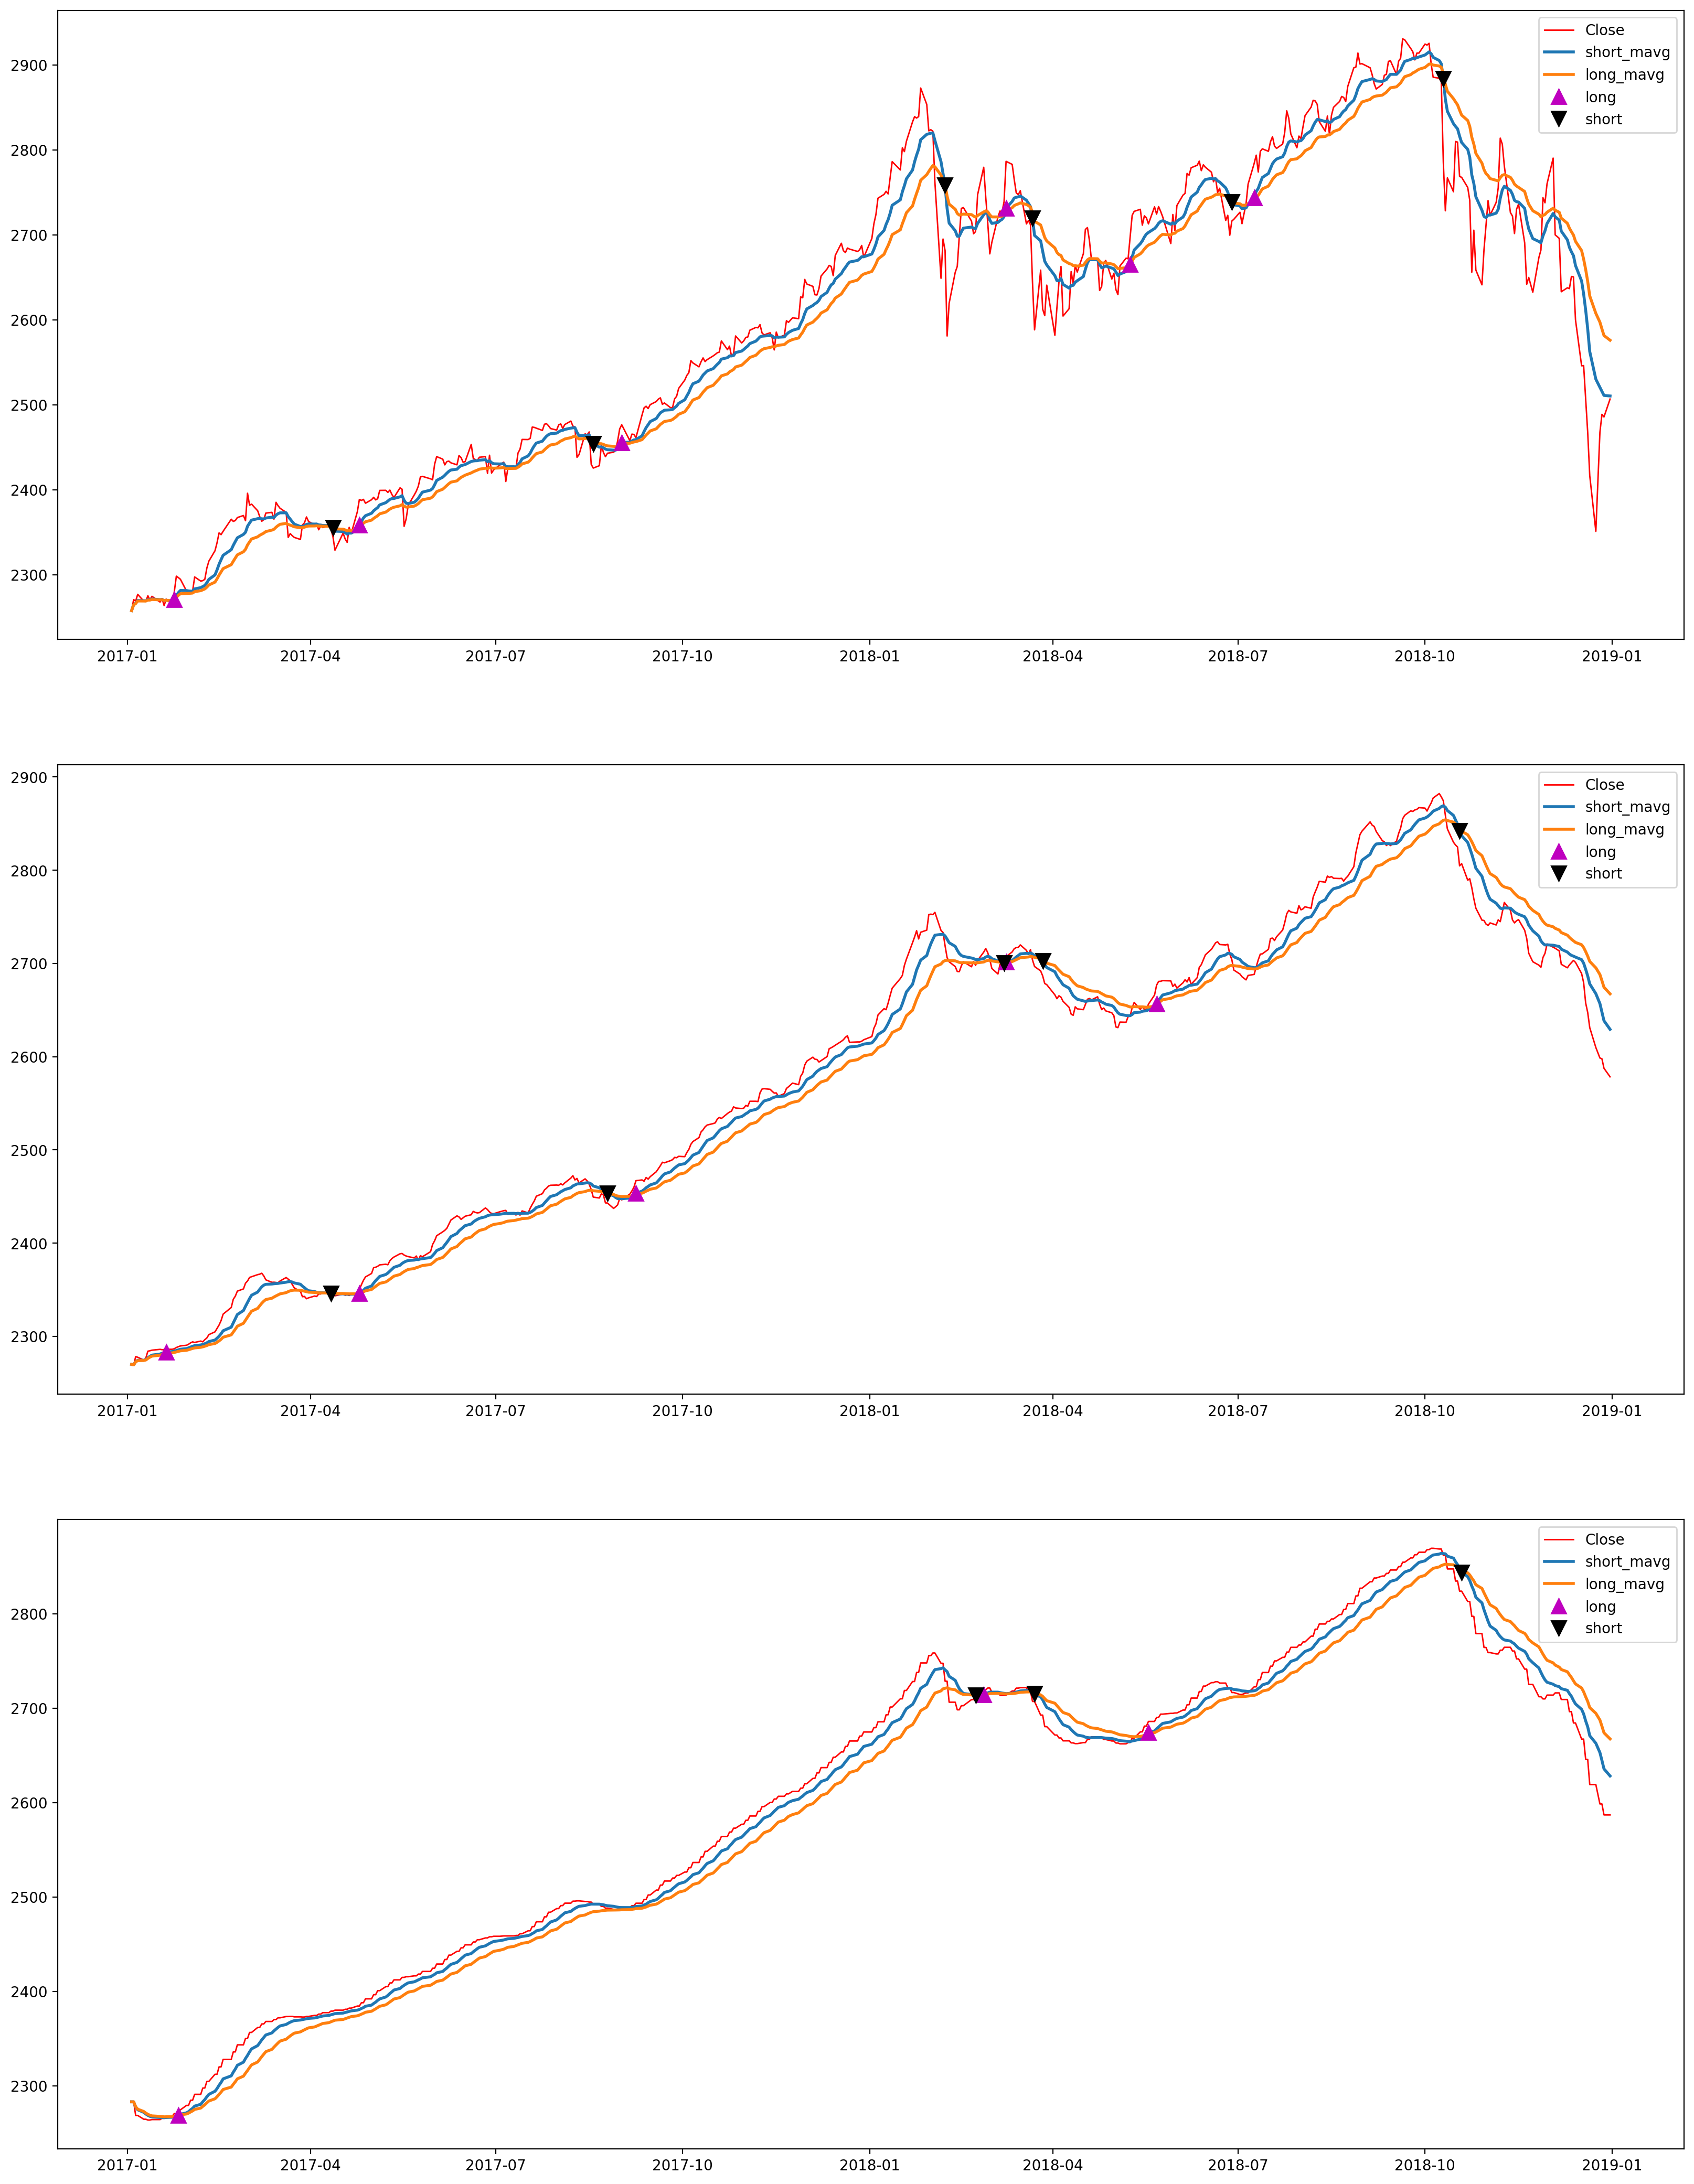

In [762]:
GSPC_test_macd=MACD(GSPC_test)
pure_mm_cnn_macd=MACD(pure_mm_cnn)
pure_mm_lstm_macd=MACD(pure_mm_lstm)

plt.figure(figsize=(20,27),dpi=200)
plt.subplot(3,1,1)
plt.plot(GSPC_test['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == 1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(GSPC_test_macd.loc[GSPC_test_macd.positions == -1.0].index, 
         GSPC_test_macd.short_mavg[GSPC_test_macd.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.plot(pure_mm_cnn['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == 1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_cnn_macd.loc[pure_mm_cnn_macd.positions == -1.0].index, 
         pure_mm_cnn_macd.short_mavg[pure_mm_cnn_macd.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

plt.subplot(3,1,3)
plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_lstm_macd[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_lstm_macd.loc[pure_mm_lstm_macd.positions == 1.0].index, 
         pure_mm_lstm_macd.short_mavg[pure_mm_lstm_macd.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_lstm_macd.loc[pure_mm_lstm_macd.positions == -1.0].index, 
         pure_mm_lstm_macd.short_mavg[pure_mm_lstm_macd.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

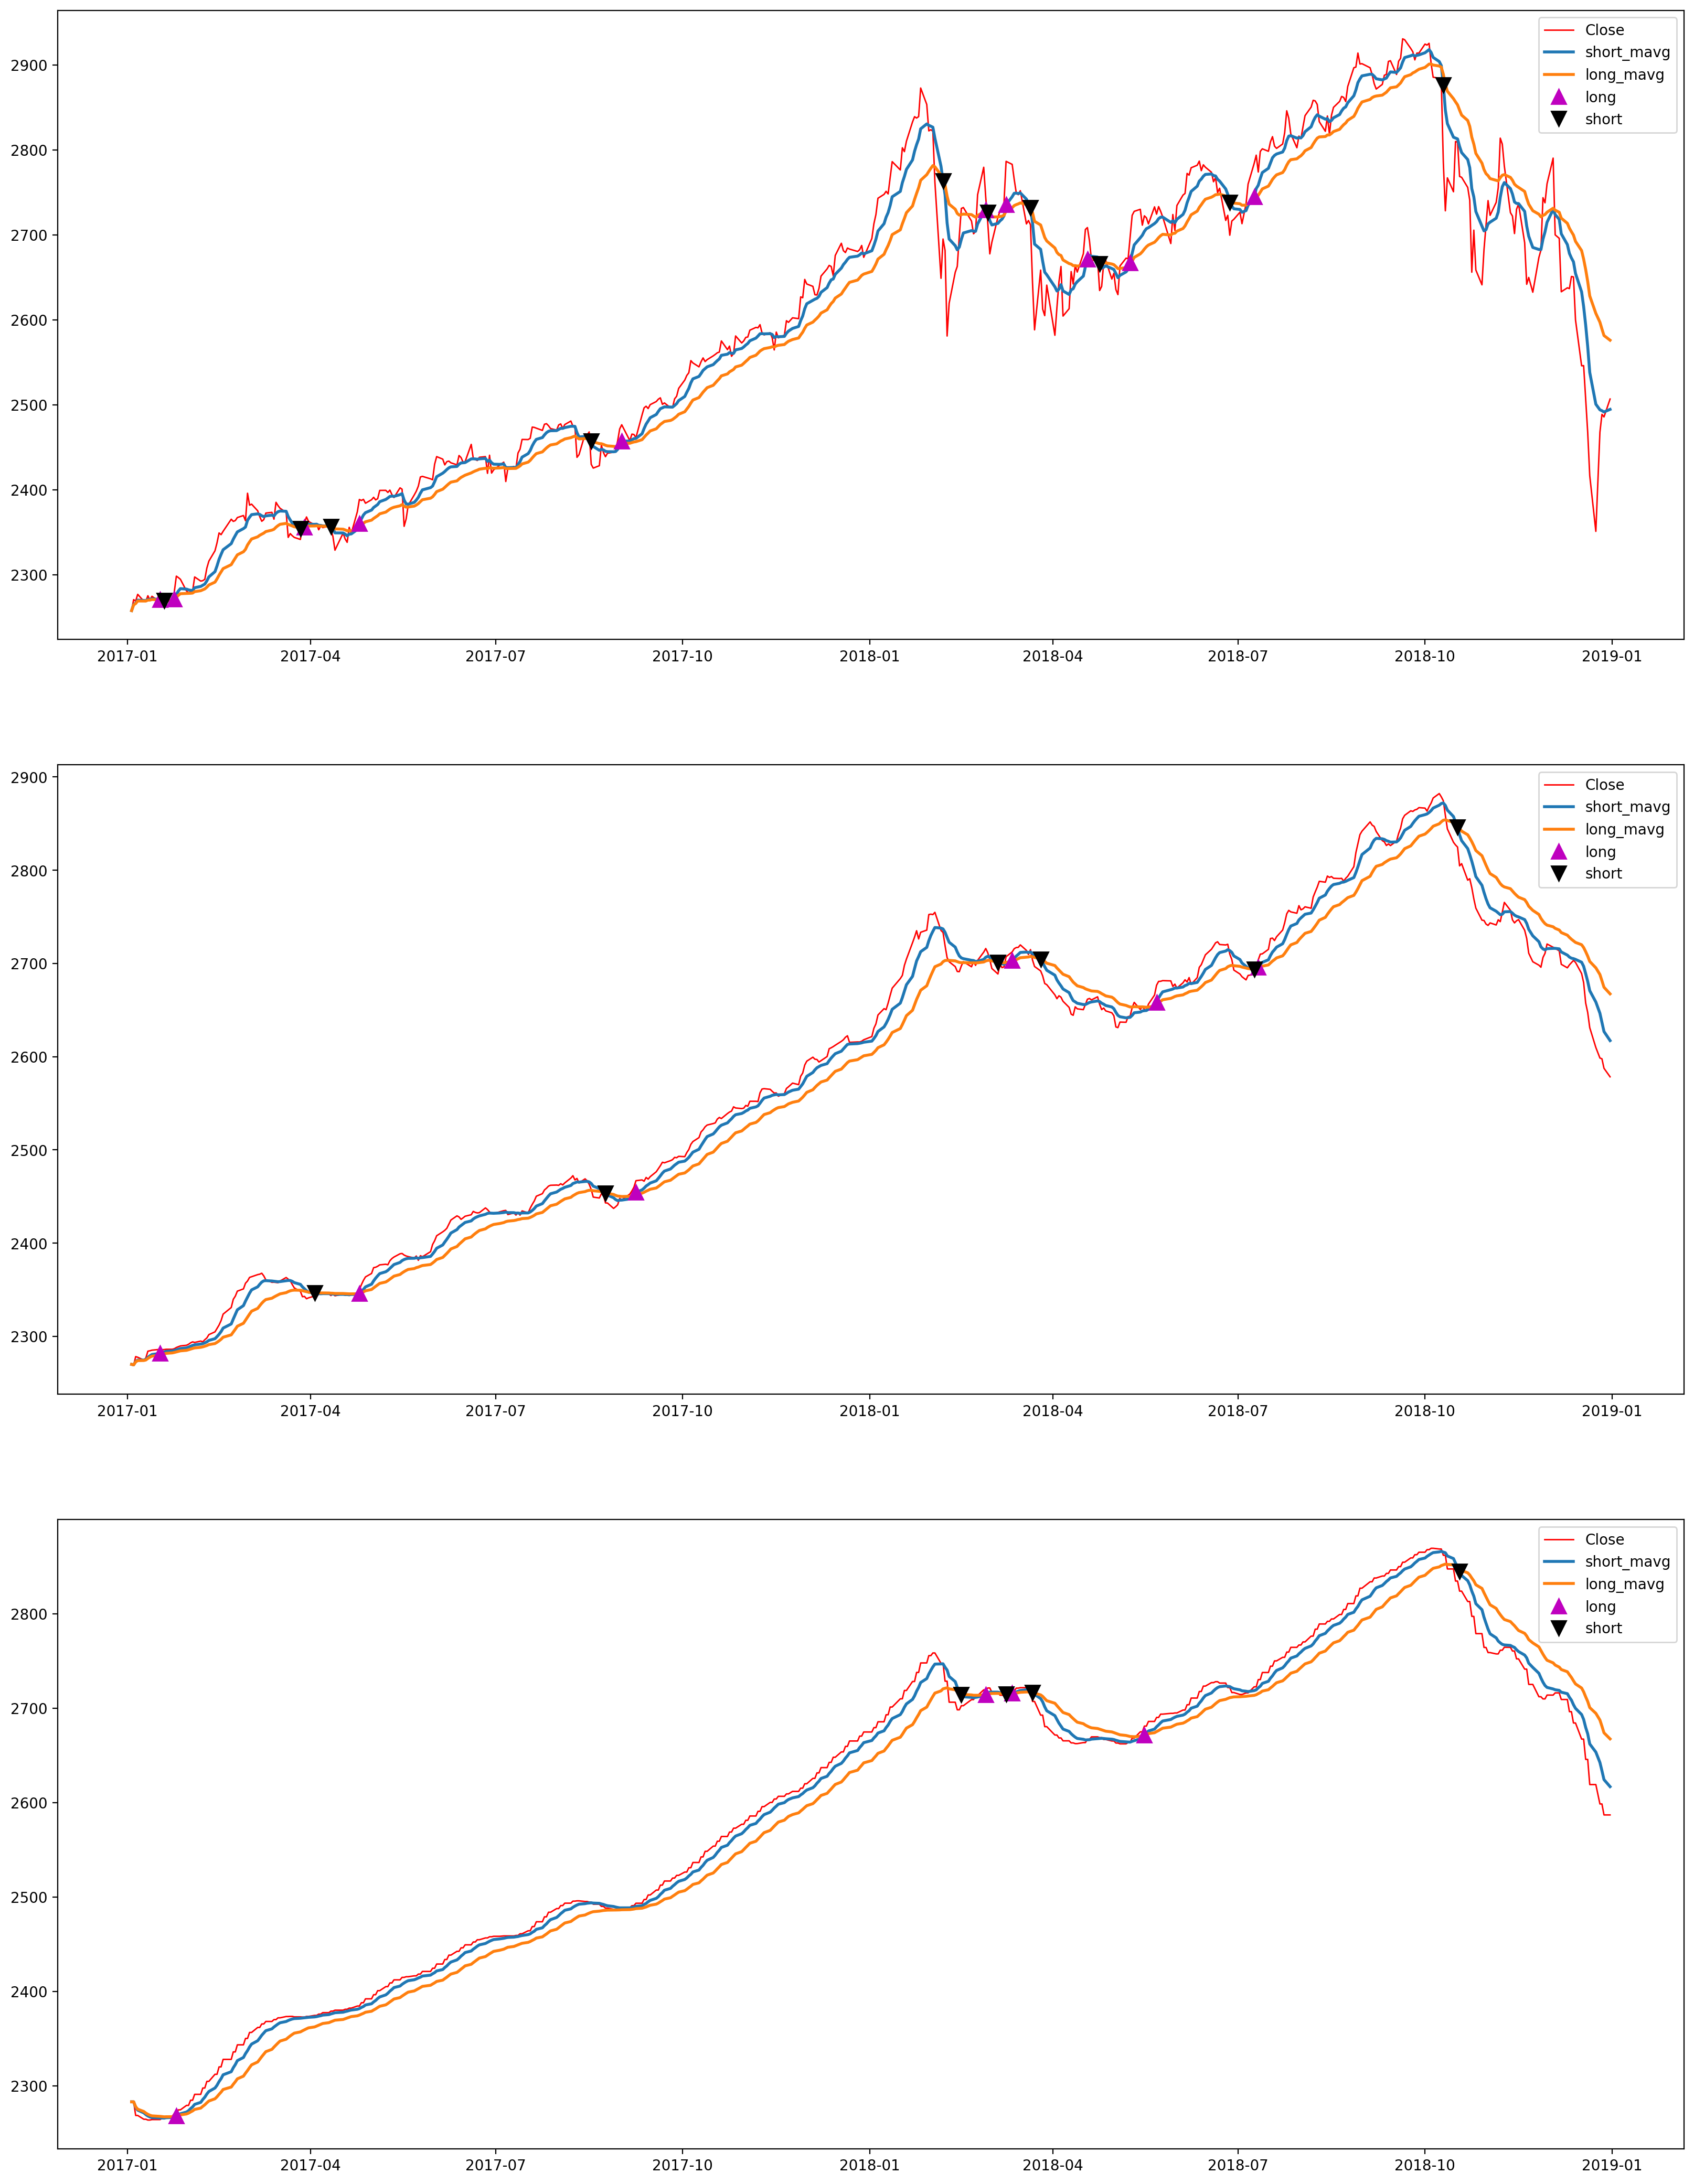

In [775]:
GSPC_test_macd9=MACD(GSPC_test,short_window = 9,long_window = 26)
pure_mm_cnn_macd9=MACD(pure_mm_cnn,short_window = 9,long_window = 26)
pure_mm_lstm_macd9=MACD(pure_mm_lstm,short_window = 9,long_window = 26)

plt.figure(figsize=(20,27),dpi=200)
plt.subplot(3,1,1)
plt.plot(GSPC_test['Close'], color='r', lw=1,label='Close')
plt.plot(GSPC_test_macd9[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(GSPC_test_macd9.loc[GSPC_test_macd9.positions == 1.0].index, 
         GSPC_test_macd9.short_mavg[GSPC_test_macd9.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(GSPC_test_macd9.loc[GSPC_test_macd9.positions == -1.0].index, 
         GSPC_test_macd9.short_mavg[GSPC_test_macd9.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()         


plt.subplot(3,1,2)
plt.plot(pure_mm_cnn['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_cnn_macd9[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_cnn_macd9.loc[pure_mm_cnn_macd9.positions == 1.0].index, 
         pure_mm_cnn_macd9.short_mavg[pure_mm_cnn_macd9.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_cnn_macd9.loc[pure_mm_cnn_macd9.positions == -1.0].index, 
         pure_mm_cnn_macd9.short_mavg[pure_mm_cnn_macd9.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

plt.subplot(3,1,3)
plt.plot(pure_mm_lstm['Close'], color='r', lw=1,label='Close')
plt.plot(pure_mm_lstm_macd9[['short_mavg', 'long_mavg']], lw=2,label=['short_mavg', 'long_mavg'])
plt.plot(pure_mm_lstm_macd9.loc[pure_mm_lstm_macd9.positions == 1.0].index, 
         pure_mm_lstm_macd9.short_mavg[pure_mm_lstm_macd9.positions == 1.0],
         '^', markersize=10, color='m',label='long')
plt.plot(pure_mm_lstm_macd9.loc[pure_mm_lstm_macd9.positions == -1.0].index, 
         pure_mm_lstm_macd9.short_mavg[pure_mm_lstm_macd9.positions == -1.0],
         'v', markersize=10, color='k',label='short')
plt.legend()   

In [758]:
GSPC_test[GSPC_test_macd['positions']!=0]

Close   log_ret
Date                             
2017-01-03  2257.830078       NaN
2017-01-24  2280.070068  0.006543
2017-04-12  2344.929932 -0.003767
2017-04-25  2388.610107  0.006072
2017-08-18  2425.550049 -0.001837
2017-09-01  2476.550049  0.001981
2018-02-07  2681.659912 -0.005014
2018-03-09  2786.570068  0.017230
2018-03-22  2643.689941 -0.025485
2018-05-09  2697.790039  0.009636
2018-06-28  2716.310059  0.006160
2018-07-09  2784.169922  0.008784
2018-10-10  2785.679932 -0.033416

In [776]:
GSPC_test[GSPC_test_macd9['positions']==1]

Close   log_ret
Date                             
2017-01-17  2267.889893 -0.002972
2017-01-24  2280.070068  0.006543
2017-03-29  2361.129883  0.001085
2017-04-25  2388.610107  0.006072
2017-09-01  2476.550049  0.001981
2018-02-27  2744.280029 -0.012788
2018-03-09  2786.570068  0.017230
2018-04-18  2708.639893  0.000831
2018-05-09  2697.790039  0.009636
2018-07-09  2784.169922  0.008784

## MA

In [ ]:
def MACD(dataset,short_window = 12,long_window = 26):
    # Initiate short and long windows

    # Initialise the `signals` dataframe and add the `signal` column
    signals = pd.DataFrame(index=dataset.index)
    signals['signal'] = 0.0

    # Calculate short term simple moving averages
    signals['short_mavg'] = dataset['Close'].ewm(span=short_window, min_periods=1).mean()

    # Calculate long term simple moving averages
    signals['long_mavg'] = dataset['Close'].ewm(span=long_window, min_periods=1).mean()

    # Generate signal
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    return signals